In [1]:
from __future__ import print_function, division
from keras.constraints import max_norm
from keras.regularizers import l2
from custom_layers import Conv1D_linearphase
from heartnet_v1 import heartnet, reshape_folds, branch
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard, Callback
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Concatenate, initializers, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd
import os
import tables
from datetime import datetime
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

Using TensorFlow backend.


In [2]:
def compute_weight(Y, classes):
    num_samples = (len(Y))
    n_classes = (len(classes))
    num_bin = np.sum(Y,axis=-2)
    class_weights = {i: (num_samples / (n_classes * num_bin[i])) for i in range(n_classes)}
    return class_weights

In [3]:
def heartnet_transfer(load_path='/home/prio/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=False,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
    x = model.layers[-4].output
    x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
    x = Dropout(rate=dropout_rate,seed=1) (x)
    x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
    x = Dropout(rate=dropout_rate, seed=1)(x)
    output = Dense(3,activation='softmax')(x)
    model = Model(inputs=model.input,outputs=output)
    plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
class log_UAR(Callback):

    def __init__(self, x_val, y_val, val_parts):
        self.x_val = x_val
        self.y_val = y_val
        self.val_parts = val_parts


    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            y_pred = self.model.predict(self.x_val, verbose=0)
            y_pred = np.argmax(y_pred, axis=-1)
            self.y_val_ = np.transpose(np.argmax(self.y_val, axis=-1))
            true = []
            pred = []
            start_idx = 0
            for s in self.val_parts:

                if not s:  ## for e00032 in validation0 there was no cardiac cycle
                    continue
                # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

                temp_ = self.y_val_[start_idx:start_idx + int(s) - 1]
                temp = y_pred[start_idx:start_idx + int(s) - 1]

                if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
                    pred.append(0)
                elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
                    pred.append(2)
                else:
                    pred.append(1)

                if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
                    true.append(0)
                elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
                    true.append(2)
                else:
                    true.append(1)

                start_idx = start_idx + int(s)

            score = recall_score(y_pred=pred, y_true=true, average='macro')
            confmat = confusion_matrix(y_pred=pred, y_true=true)
            logs['recall0'] = confmat[0,0]/np.sum(confmat[0,:])
            logs['recall1'] = confmat[1,1]/np.sum(confmat[1,:])
            logs['recall2'] = confmat[2,2]/np.sum(confmat[2,:])
            logs['UAR'] = np.mean([logs['recall0'],logs['recall1'],logs['recall2']])

NameError: name 'Callback' is not defined

In [5]:
fold_dir = '/home/prio/heart_sound/feature/segmented_noFIR/'
foldname = 'comParE'
model_dir = '/home/prio/heart_sound/models/'
log_dir = '/home/prio/heart_sound/logs/'

##### Load Model ######
load_path='/home/prio/heart_sound/weights.0148-0.8902.hdf5'
# lr = 0.00001
lr = 0.006028585143146318
num_dense1 = 1458 #34,120,167,239,1239,650,788,422,598
num_dense2 = 179 #121,
epochs = 45
batch_size = 256
# dropout_rate = 0.
trainable = True
addweights = True

In [6]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]
############### Reshaping ############
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)

(17061, 2500, 1)
(17061, 1)
(5872, 2500, 1)
(5872, 1)


In [7]:
def objective(args):
    #### Parse arguments and print #####
    
    print("args %s" % args)
    
#     lr = args['lr']
#     num_dense1 = args['num_dense1']
#     num_dense2 = args['num_dense2']
    dropout_rate = args['dropout_rate']
    
    ##### Load model ######
    model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)
    
    #### Log params #####
    log_name = foldname + ' ' + str(datetime.now()) + str([lr,num_dense1,num_dense2])
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
    
    ### Callbacks ###
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                    monitor='val_acc', save_best_only=False, mode='max')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                         batch_size=batch_size,
                         # histogram_freq=100,
                         # embeddings_freq=99,
                         # embeddings_layer_names=embedding_layer_names,
                         # embeddings_data=x_val,
                         # embeddings_metadata=metadata_file,
                         write_images=False)
    class_weights=compute_weight(y_train,range(3))
    print("Class weights %s" % class_weights)

    #### Train ####
    
    history = model.fit(x_train,y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[modelcheckpnt,
                        log_UAR(x_val, y_val, val_parts),
                        tensbd, csv_logger],
                        validation_data=(x_val,y_val))
#     print("History : %s" % history.history)
    loss = history.history['UAR']
#     print(loss)
    K.clear_session()
#     return (1.- np.float32(np.max(loss)))
    return {'loss': 1.- np.float32(np.max(loss)), 'status': STATUS_OK}

In [8]:
space = {
#     'lr' : 10 ** hp.uniform('lr',-6,-2),
#     'num_dense1' : 1000 + hp.randint('num_dense1',1500),
#     'num_dense2' : 80 + hp.randint('num_dense2',140),
    'dropout_rate' : hp.uniform('dropout_rate',0,1)
}

In [9]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=20)
print('best:', best)

args {'lr': 0.00029060057084501803, 'num_dense1': 436, 'num_dense2': 301}
Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3465 - acc: 0.3403 - val_loss: 1.1513 - val_acc: 0.3551
Epoch 2/45
4s - loss: 1.2726 - acc: 0.3682 - val_loss: 1.1614 - val_acc: 0.3484
Epoch 3/45
4s - loss: 1.2385 - acc: 0.3802 - val_loss: 1.1560 - val_acc: 0.3605
Epoch 4/45
4s - loss: 1.2057 - acc: 0.3924 - val_loss: 1.1658 - val_acc: 0.3483
Epoch 5/45
4s - loss: 1.1816 - acc: 0.4020 - val_loss: 1.1738 - val_acc: 0.3409
Epoch 6/45
4s - loss: 1.1565 - acc: 0.4105 - val_loss: 1.1680 - val_acc: 0.3466
Epoch 7/45
4s - loss: 1.1568 - acc: 0.4119 - val_loss: 1.1879 - val_acc: 0.3273
Epoch 8/45
4s - loss: 1.1381 - acc: 0.4198 - val_loss: 1.1869 - val_acc: 0.3319
Epoch 9/45
4s - loss: 1.1239 - acc: 0.4332 - val_loss: 1.1868 - val_acc: 0.3328
Epoch 10/45
4s - loss: 1.1093 - acc: 0.4333 - val_loss: 1.1823 - val_acc

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3155 - acc: 0.3492 - val_loss: 1.1783 - val_acc: 0.3275
Epoch 2/45
4s - loss: 1.1846 - acc: 0.3944 - val_loss: 1.1566 - val_acc: 0.3573
Epoch 3/45
4s - loss: 1.1489 - acc: 0.4166 - val_loss: 1.1745 - val_acc: 0.3334
Epoch 4/45
4s - loss: 1.1108 - acc: 0.4319 - val_loss: 1.1947 - val_acc: 0.3292
Epoch 5/45
4s - loss: 1.0795 - acc: 0.4509 - val_loss: 1.1974 - val_acc: 0.3191
Epoch 6/45
4s - loss: 1.0614 - acc: 0.4564 - val_loss: 1.1730 - val_acc: 0.3404
Epoch 7/45
4s - loss: 1.0462 - acc: 0.4698 - val_loss: 1.1670 - val_acc: 0.3421
Epoch 8/45
4s - loss: 1.0351 - acc: 0.4738 - val_loss: 1.1754 - val_acc: 0.3336
Epoch 9/45
4s - loss: 1.0203 - acc: 0.4815 - val_loss: 1.1728 - val_acc: 0.3333
Epoch 10/45
4s - loss: 1.0075 - acc: 0.4914 - val_loss: 1.1629 - val_acc: 0.3387
Epoch 11/45
4s - loss: 1.0076 - acc: 0.4887 - val_loss: 1.1788 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1661 - acc: 0.4167 - val_loss: 1.1447 - val_acc: 0.3363
Epoch 2/45
4s - loss: 0.9957 - acc: 0.4885 - val_loss: 1.1325 - val_acc: 0.3621
Epoch 3/45
4s - loss: 0.9358 - acc: 0.5300 - val_loss: 1.1959 - val_acc: 0.3365
Epoch 4/45
4s - loss: 0.9007 - acc: 0.5563 - val_loss: 1.1857 - val_acc: 0.3324
Epoch 5/45
4s - loss: 0.8661 - acc: 0.5842 - val_loss: 1.1279 - val_acc: 0.3970
Epoch 6/45
4s - loss: 0.8322 - acc: 0.6039 - val_loss: 1.2298 - val_acc: 0.3336
Epoch 7/45
4s - loss: 0.8006 - acc: 0.6234 - val_loss: 1.2418 - val_acc: 0.3280
Epoch 8/45
4s - loss: 0.7716 - acc: 0.6371 - val_loss: 1.2270 - val_acc: 0.3420
Epoch 9/45
4s - loss: 0.7487 - acc: 0.6517 - val_loss: 1.2141 - val_acc: 0.3520
Epoch 10/45
4s - loss: 0.7233 - acc: 0.6613 - val_loss: 1.2129 - val_acc: 0.3547
Epoch 11/45
4s - loss: 0.6921 - acc: 0.6801 - val_loss: 1.2419 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2423 - acc: 0.3739 - val_loss: 1.1407 - val_acc: 0.3677
Epoch 2/45
4s - loss: 1.1194 - acc: 0.4314 - val_loss: 1.1709 - val_acc: 0.3423
Epoch 3/45
4s - loss: 1.0754 - acc: 0.4609 - val_loss: 1.1721 - val_acc: 0.3442
Epoch 4/45
4s - loss: 1.0349 - acc: 0.4766 - val_loss: 1.1790 - val_acc: 0.3443
Epoch 5/45
4s - loss: 1.0143 - acc: 0.4933 - val_loss: 1.1692 - val_acc: 0.3665
Epoch 6/45
4s - loss: 0.9884 - acc: 0.5075 - val_loss: 1.2060 - val_acc: 0.3287
Epoch 7/45
4s - loss: 0.9656 - acc: 0.5187 - val_loss: 1.2183 - val_acc: 0.3193
Epoch 8/45
4s - loss: 0.9576 - acc: 0.5243 - val_loss: 1.1835 - val_acc: 0.3501
Epoch 9/45
4s - loss: 0.9349 - acc: 0.5402 - val_loss: 1.1678 - val_acc: 0.3701
Epoch 10/45
4s - loss: 0.9257 - acc: 0.5483 - val_loss: 1.1935 - val_acc: 0.3392
Epoch 11/45
4s - loss: 0.9125 - acc: 0.5512 - val_loss: 1.1898 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4087 - acc: 0.3023 - val_loss: 1.1498 - val_acc: 0.3787
Epoch 2/45
4s - loss: 1.3158 - acc: 0.3444 - val_loss: 1.1527 - val_acc: 0.3782
Epoch 3/45
4s - loss: 1.2770 - acc: 0.3582 - val_loss: 1.1592 - val_acc: 0.3753
Epoch 4/45
4s - loss: 1.2370 - acc: 0.3730 - val_loss: 1.1636 - val_acc: 0.3624
Epoch 5/45
4s - loss: 1.2228 - acc: 0.3740 - val_loss: 1.1762 - val_acc: 0.3544
Epoch 6/45
4s - loss: 1.1942 - acc: 0.3872 - val_loss: 1.1746 - val_acc: 0.3552
Epoch 7/45
4s - loss: 1.1747 - acc: 0.3989 - val_loss: 1.1820 - val_acc: 0.3539
Epoch 8/45
6s - loss: 1.1587 - acc: 0.4122 - val_loss: 1.1887 - val_acc: 0.3421
Epoch 9/45
4s - loss: 1.1472 - acc: 0.4157 - val_loss: 1.1914 - val_acc: 0.3394
Epoch 10/45
4s - loss: 1.1395 - acc: 0.4187 - val_loss: 1.1917 - val_acc: 0.3370
Epoch 11/45
4s - loss: 1.1239 - acc: 0.4287 - val_loss: 1.1837 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2334 - acc: 0.3854 - val_loss: 1.1508 - val_acc: 0.3379
Epoch 2/45
4s - loss: 1.1131 - acc: 0.4291 - val_loss: 1.1458 - val_acc: 0.3561
Epoch 3/45
4s - loss: 1.0600 - acc: 0.4640 - val_loss: 1.1964 - val_acc: 0.3263
Epoch 4/45
4s - loss: 1.0294 - acc: 0.4713 - val_loss: 1.1772 - val_acc: 0.3460
Epoch 5/45
4s - loss: 0.9974 - acc: 0.4905 - val_loss: 1.1812 - val_acc: 0.3450
Epoch 6/45
4s - loss: 0.9744 - acc: 0.5109 - val_loss: 1.1899 - val_acc: 0.3351
Epoch 7/45
4s - loss: 0.9653 - acc: 0.5193 - val_loss: 1.1900 - val_acc: 0.3467
Epoch 8/45
4s - loss: 0.9450 - acc: 0.5319 - val_loss: 1.1954 - val_acc: 0.3476
Epoch 9/45
4s - loss: 0.9354 - acc: 0.5381 - val_loss: 1.1959 - val_acc: 0.3476
Epoch 10/45
4s - loss: 0.9163 - acc: 0.5524 - val_loss: 1.2054 - val_acc: 0.3338
Epoch 11/45
4s - loss: 0.9053 - acc: 0.5576 - val_loss: 1.2223 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1868 - acc: 0.4019 - val_loss: 1.1220 - val_acc: 0.3440
Epoch 2/45
4s - loss: 0.9907 - acc: 0.4887 - val_loss: 1.1361 - val_acc: 0.3454
Epoch 3/45
4s - loss: 0.9322 - acc: 0.5348 - val_loss: 1.1551 - val_acc: 0.3225
Epoch 4/45
4s - loss: 0.8936 - acc: 0.5617 - val_loss: 1.1830 - val_acc: 0.3353
Epoch 5/45
4s - loss: 0.8553 - acc: 0.5845 - val_loss: 1.1301 - val_acc: 0.3779
Epoch 6/45
4s - loss: 0.8259 - acc: 0.6064 - val_loss: 1.2030 - val_acc: 0.3462
Epoch 7/45
4s - loss: 0.7817 - acc: 0.6339 - val_loss: 1.2035 - val_acc: 0.3399
Epoch 8/45
4s - loss: 0.7548 - acc: 0.6450 - val_loss: 1.2152 - val_acc: 0.3413
Epoch 9/45
4s - loss: 0.7283 - acc: 0.6623 - val_loss: 1.2022 - val_acc: 0.3569
Epoch 10/45
4s - loss: 0.7093 - acc: 0.6728 - val_loss: 1.2366 - val_acc: 0.3534
Epoch 11/45
4s - loss: 0.6779 - acc: 0.6823 - val_loss: 1.2027 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2874 - acc: 0.3662 - val_loss: 1.1190 - val_acc: 0.3917
Epoch 2/45
4s - loss: 1.1580 - acc: 0.4123 - val_loss: 1.1640 - val_acc: 0.3408
Epoch 3/45
4s - loss: 1.1007 - acc: 0.4402 - val_loss: 1.1737 - val_acc: 0.3522
Epoch 4/45
4s - loss: 1.0632 - acc: 0.4586 - val_loss: 1.1876 - val_acc: 0.3401
Epoch 5/45
4s - loss: 1.0397 - acc: 0.4746 - val_loss: 1.1697 - val_acc: 0.3510
Epoch 6/45
4s - loss: 1.0169 - acc: 0.4846 - val_loss: 1.2107 - val_acc: 0.3171
Epoch 7/45
4s - loss: 0.9962 - acc: 0.4916 - val_loss: 1.1913 - val_acc: 0.3442
Epoch 8/45
4s - loss: 0.9860 - acc: 0.5041 - val_loss: 1.2132 - val_acc: 0.3232
Epoch 9/45
4s - loss: 0.9791 - acc: 0.5132 - val_loss: 1.2036 - val_acc: 0.3248
Epoch 10/45
4s - loss: 0.9581 - acc: 0.5179 - val_loss: 1.2211 - val_acc: 0.3179
Epoch 11/45
4s - loss: 0.9421 - acc: 0.5300 - val_loss: 1.2133 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3595 - acc: 0.3474 - val_loss: 1.1786 - val_acc: 0.3006
Epoch 2/45
4s - loss: 1.3187 - acc: 0.3438 - val_loss: 1.1737 - val_acc: 0.3081
Epoch 3/45
4s - loss: 1.2896 - acc: 0.3568 - val_loss: 1.1821 - val_acc: 0.3038
Epoch 4/45
4s - loss: 1.2673 - acc: 0.3676 - val_loss: 1.1901 - val_acc: 0.3004
Epoch 5/45
4s - loss: 1.2526 - acc: 0.3704 - val_loss: 1.1851 - val_acc: 0.3091
Epoch 6/45
5s - loss: 1.2420 - acc: 0.3692 - val_loss: 1.1823 - val_acc: 0.3161
Epoch 7/45
4s - loss: 1.2187 - acc: 0.3825 - val_loss: 1.1940 - val_acc: 0.3045
Epoch 8/45
4s - loss: 1.2163 - acc: 0.3874 - val_loss: 1.1927 - val_acc: 0.3045
Epoch 9/45
4s - loss: 1.2057 - acc: 0.3915 - val_loss: 1.1931 - val_acc: 0.3071
Epoch 10/45
4s - loss: 1.1992 - acc: 0.3890 - val_loss: 1.1913 - val_acc: 0.3164
Epoch 11/45
4s - loss: 1.1797 - acc: 0.4035 - val_loss: 1.1924 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4269 - acc: 0.2929 - val_loss: 1.2078 - val_acc: 0.3181
Epoch 2/45
4s - loss: 1.4230 - acc: 0.2958 - val_loss: 1.2209 - val_acc: 0.3166
Epoch 3/45
4s - loss: 1.4052 - acc: 0.3097 - val_loss: 1.2296 - val_acc: 0.3212
Epoch 4/45
4s - loss: 1.3887 - acc: 0.3138 - val_loss: 1.2338 - val_acc: 0.3225
Epoch 5/45
4s - loss: 1.3774 - acc: 0.3193 - val_loss: 1.2350 - val_acc: 0.3236
Epoch 6/45
4s - loss: 1.3861 - acc: 0.3243 - val_loss: 1.2355 - val_acc: 0.3260
Epoch 7/45
4s - loss: 1.3752 - acc: 0.3250 - val_loss: 1.2343 - val_acc: 0.3278
Epoch 8/45
4s - loss: 1.3865 - acc: 0.3251 - val_loss: 1.2337 - val_acc: 0.3314
Epoch 9/45
4s - loss: 1.3659 - acc: 0.3340 - val_loss: 1.2323 - val_acc: 0.3350
Epoch 10/45
4s - loss: 1.3582 - acc: 0.3338 - val_loss: 1.2318 - val_acc: 0.3362
Epoch 11/45
4s - loss: 1.3658 - acc: 0.3329 - val_loss: 1.2315 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4792 - acc: 0.4283 - val_loss: 1.0914 - val_acc: 0.4361
Epoch 2/45
4s - loss: 1.4311 - acc: 0.4109 - val_loss: 1.1048 - val_acc: 0.4074
Epoch 3/45
4s - loss: 1.4161 - acc: 0.3871 - val_loss: 1.1176 - val_acc: 0.3919
Epoch 4/45
4s - loss: 1.3931 - acc: 0.3762 - val_loss: 1.1291 - val_acc: 0.3784
Epoch 5/45
4s - loss: 1.3957 - acc: 0.3650 - val_loss: 1.1387 - val_acc: 0.3638
Epoch 6/45
4s - loss: 1.3729 - acc: 0.3588 - val_loss: 1.1463 - val_acc: 0.3498
Epoch 7/45
4s - loss: 1.3876 - acc: 0.3438 - val_loss: 1.1517 - val_acc: 0.3433
Epoch 8/45
4s - loss: 1.3741 - acc: 0.3414 - val_loss: 1.1563 - val_acc: 0.3399
Epoch 9/45
4s - loss: 1.3667 - acc: 0.3391 - val_loss: 1.1595 - val_acc: 0.3363
Epoch 10/45
4s - loss: 1.3780 - acc: 0.3370 - val_loss: 1.1620 - val_acc: 0.3353
Epoch 11/45
4s - loss: 1.3737 - acc: 0.3384 - val_loss: 1.1641 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2268 - acc: 0.3915 - val_loss: 1.1252 - val_acc: 0.3908
Epoch 2/45
4s - loss: 1.0832 - acc: 0.4472 - val_loss: 1.1584 - val_acc: 0.3529
Epoch 3/45
4s - loss: 1.0214 - acc: 0.4873 - val_loss: 1.2036 - val_acc: 0.3231
Epoch 4/45
4s - loss: 0.9943 - acc: 0.5030 - val_loss: 1.1921 - val_acc: 0.3280
Epoch 5/45
4s - loss: 0.9625 - acc: 0.5157 - val_loss: 1.1811 - val_acc: 0.3384
Epoch 6/45
4s - loss: 0.9436 - acc: 0.5316 - val_loss: 1.2109 - val_acc: 0.3334
Epoch 7/45
4s - loss: 0.9219 - acc: 0.5451 - val_loss: 1.2116 - val_acc: 0.3266
Epoch 8/45
4s - loss: 0.9017 - acc: 0.5583 - val_loss: 1.2408 - val_acc: 0.3282
Epoch 9/45
4s - loss: 0.8903 - acc: 0.5639 - val_loss: 1.1980 - val_acc: 0.3449
Epoch 10/45
4s - loss: 0.8704 - acc: 0.5744 - val_loss: 1.2337 - val_acc: 0.3295
Epoch 11/45
4s - loss: 0.8528 - acc: 0.5853 - val_loss: 1.2247 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3517 - acc: 0.3432 - val_loss: 1.1597 - val_acc: 0.3229
Epoch 2/45
4s - loss: 1.2513 - acc: 0.3718 - val_loss: 1.1768 - val_acc: 0.3219
Epoch 3/45
4s - loss: 1.1979 - acc: 0.3878 - val_loss: 1.1753 - val_acc: 0.3336
Epoch 4/45
4s - loss: 1.1642 - acc: 0.4065 - val_loss: 1.1854 - val_acc: 0.3278
Epoch 5/45
4s - loss: 1.1286 - acc: 0.4225 - val_loss: 1.1912 - val_acc: 0.3260
Epoch 6/45
4s - loss: 1.1101 - acc: 0.4333 - val_loss: 1.1862 - val_acc: 0.3334
Epoch 7/45
4s - loss: 1.0943 - acc: 0.4455 - val_loss: 1.1967 - val_acc: 0.3294
Epoch 8/45
4s - loss: 1.0762 - acc: 0.4484 - val_loss: 1.1978 - val_acc: 0.3317
Epoch 9/45
4s - loss: 1.0715 - acc: 0.4578 - val_loss: 1.1952 - val_acc: 0.3346
Epoch 10/45
4s - loss: 1.0634 - acc: 0.4576 - val_loss: 1.1900 - val_acc: 0.3365
Epoch 11/45
4s - loss: 1.0476 - acc: 0.4631 - val_loss: 1.1826 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.8798 - acc: 0.1847 - val_loss: 1.4824 - val_acc: 0.2006
Epoch 2/45
4s - loss: 1.8211 - acc: 0.1866 - val_loss: 1.4855 - val_acc: 0.2027
Epoch 3/45
4s - loss: 1.7764 - acc: 0.1894 - val_loss: 1.4787 - val_acc: 0.2050
Epoch 4/45
4s - loss: 1.7346 - acc: 0.1945 - val_loss: 1.4629 - val_acc: 0.2067
Epoch 5/45
4s - loss: 1.6822 - acc: 0.2004 - val_loss: 1.4452 - val_acc: 0.2098
Epoch 6/45
4s - loss: 1.6448 - acc: 0.2042 - val_loss: 1.4263 - val_acc: 0.2159
Epoch 7/45
4s - loss: 1.6032 - acc: 0.2112 - val_loss: 1.4074 - val_acc: 0.2178
Epoch 8/45
4s - loss: 1.5762 - acc: 0.2132 - val_loss: 1.3896 - val_acc: 0.2219
Epoch 9/45
4s - loss: 1.5443 - acc: 0.2192 - val_loss: 1.3746 - val_acc: 0.2274
Epoch 10/45
4s - loss: 1.5172 - acc: 0.2236 - val_loss: 1.3601 - val_acc: 0.2318
Epoch 11/45
5s - loss: 1.4977 - acc: 0.2330 - val_loss: 1.3463 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.5856 - acc: 0.2805 - val_loss: 1.1959 - val_acc: 0.2880
Epoch 2/45
4s - loss: 1.5649 - acc: 0.2928 - val_loss: 1.1905 - val_acc: 0.3014
Epoch 3/45
4s - loss: 1.5360 - acc: 0.2973 - val_loss: 1.1854 - val_acc: 0.3125
Epoch 4/45
4s - loss: 1.5181 - acc: 0.3013 - val_loss: 1.1803 - val_acc: 0.3217
Epoch 5/45
4s - loss: 1.5061 - acc: 0.3022 - val_loss: 1.1751 - val_acc: 0.3278
Epoch 6/45
4s - loss: 1.5055 - acc: 0.3010 - val_loss: 1.1700 - val_acc: 0.3333
Epoch 7/45
4s - loss: 1.4904 - acc: 0.3114 - val_loss: 1.1653 - val_acc: 0.3382
Epoch 8/45
4s - loss: 1.4744 - acc: 0.3130 - val_loss: 1.1615 - val_acc: 0.3438
Epoch 9/45
5s - loss: 1.4702 - acc: 0.3173 - val_loss: 1.1577 - val_acc: 0.3476
Epoch 10/45
4s - loss: 1.4612 - acc: 0.3185 - val_loss: 1.1542 - val_acc: 0.3518
Epoch 11/45
4s - loss: 1.4482 - acc: 0.3173 - val_loss: 1.1512 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3564 - acc: 0.3563 - val_loss: 1.1317 - val_acc: 0.3619
Epoch 2/45
4s - loss: 1.2678 - acc: 0.3712 - val_loss: 1.1456 - val_acc: 0.3644
Epoch 3/45
4s - loss: 1.2194 - acc: 0.3955 - val_loss: 1.1609 - val_acc: 0.3520
Epoch 4/45
4s - loss: 1.1927 - acc: 0.4037 - val_loss: 1.1702 - val_acc: 0.3479
Epoch 5/45
4s - loss: 1.1688 - acc: 0.4168 - val_loss: 1.1845 - val_acc: 0.3387
Epoch 6/45
4s - loss: 1.1362 - acc: 0.4290 - val_loss: 1.1900 - val_acc: 0.3375
Epoch 7/45
4s - loss: 1.1374 - acc: 0.4333 - val_loss: 1.1881 - val_acc: 0.3314
Epoch 8/45
4s - loss: 1.1226 - acc: 0.4327 - val_loss: 1.1930 - val_acc: 0.3341
Epoch 9/45
4s - loss: 1.1200 - acc: 0.4380 - val_loss: 1.1964 - val_acc: 0.3297
Epoch 10/45
4s - loss: 1.1002 - acc: 0.4438 - val_loss: 1.1961 - val_acc: 0.3203
Epoch 11/45
4s - loss: 1.0869 - acc: 0.4508 - val_loss: 1.2062 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.5255 - acc: 0.3175 - val_loss: 1.1856 - val_acc: 0.3285
Epoch 2/45
4s - loss: 1.4421 - acc: 0.3278 - val_loss: 1.1714 - val_acc: 0.3375
Epoch 3/45
4s - loss: 1.4157 - acc: 0.3312 - val_loss: 1.1646 - val_acc: 0.3479
Epoch 4/45
4s - loss: 1.3995 - acc: 0.3366 - val_loss: 1.1626 - val_acc: 0.3508
Epoch 5/45
4s - loss: 1.3884 - acc: 0.3357 - val_loss: 1.1607 - val_acc: 0.3534
Epoch 6/45
4s - loss: 1.3774 - acc: 0.3392 - val_loss: 1.1598 - val_acc: 0.3551
Epoch 7/45
4s - loss: 1.3727 - acc: 0.3388 - val_loss: 1.1588 - val_acc: 0.3552
Epoch 8/45
4s - loss: 1.3620 - acc: 0.3486 - val_loss: 1.1581 - val_acc: 0.3581
Epoch 9/45
4s - loss: 1.3596 - acc: 0.3456 - val_loss: 1.1578 - val_acc: 0.3593
Epoch 10/45
4s - loss: 1.3685 - acc: 0.3435 - val_loss: 1.1565 - val_acc: 0.3614
Epoch 11/45
4s - loss: 1.3459 - acc: 0.3476 - val_loss: 1.1559 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4552 - acc: 0.3668 - val_loss: 1.1939 - val_acc: 0.3288
Epoch 2/45
4s - loss: 1.3710 - acc: 0.3466 - val_loss: 1.1882 - val_acc: 0.3200
Epoch 3/45
4s - loss: 1.3288 - acc: 0.3538 - val_loss: 1.1865 - val_acc: 0.3174
Epoch 4/45
4s - loss: 1.3042 - acc: 0.3578 - val_loss: 1.1787 - val_acc: 0.3243
Epoch 5/45
4s - loss: 1.2661 - acc: 0.3711 - val_loss: 1.1811 - val_acc: 0.3248
Epoch 6/45
4s - loss: 1.2510 - acc: 0.3747 - val_loss: 1.1853 - val_acc: 0.3157
Epoch 7/45
4s - loss: 1.2401 - acc: 0.3680 - val_loss: 1.1790 - val_acc: 0.3239
Epoch 8/45
4s - loss: 1.2166 - acc: 0.3898 - val_loss: 1.1827 - val_acc: 0.3205
Epoch 9/45
4s - loss: 1.2094 - acc: 0.3926 - val_loss: 1.1773 - val_acc: 0.3280
Epoch 10/45
4s - loss: 1.1942 - acc: 0.3927 - val_loss: 1.1787 - val_acc: 0.3265
Epoch 11/45
4s - loss: 1.1839 - acc: 0.3948 - val_loss: 1.1756 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2797 - acc: 0.3463 - val_loss: 1.1470 - val_acc: 0.3392
Epoch 2/45
4s - loss: 1.1863 - acc: 0.3938 - val_loss: 1.1495 - val_acc: 0.3488
Epoch 3/45
4s - loss: 1.1303 - acc: 0.4313 - val_loss: 1.1804 - val_acc: 0.3185
Epoch 4/45
4s - loss: 1.1058 - acc: 0.4350 - val_loss: 1.1512 - val_acc: 0.3581
Epoch 5/45
4s - loss: 1.0810 - acc: 0.4550 - val_loss: 1.1765 - val_acc: 0.3334
Epoch 6/45
4s - loss: 1.0557 - acc: 0.4720 - val_loss: 1.1873 - val_acc: 0.3394
Epoch 7/45
4s - loss: 1.0321 - acc: 0.4836 - val_loss: 1.1799 - val_acc: 0.3357
Epoch 8/45
4s - loss: 1.0172 - acc: 0.4868 - val_loss: 1.1763 - val_acc: 0.3447
Epoch 9/45
4s - loss: 1.0136 - acc: 0.4920 - val_loss: 1.1917 - val_acc: 0.3312
Epoch 10/45
4s - loss: 0.9937 - acc: 0.5064 - val_loss: 1.1970 - val_acc: 0.3263
Epoch 11/45
4s - loss: 0.9820 - acc: 0.5119 - val_loss: 1.1957 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2050 - acc: 0.3434 - val_loss: 1.1195 - val_acc: 0.3016
Epoch 2/45
5s - loss: 1.1081 - acc: 0.3673 - val_loss: 1.1194 - val_acc: 0.3069
Epoch 3/45
4s - loss: 1.0840 - acc: 0.3994 - val_loss: 1.1186 - val_acc: 0.3231
Epoch 4/45
4s - loss: 1.0705 - acc: 0.4082 - val_loss: 1.1280 - val_acc: 0.3096
Epoch 5/45
4s - loss: 1.0590 - acc: 0.4219 - val_loss: 1.1220 - val_acc: 0.3323
Epoch 6/45
4s - loss: 1.0489 - acc: 0.4360 - val_loss: 1.1372 - val_acc: 0.3164
Epoch 7/45
4s - loss: 1.0343 - acc: 0.4452 - val_loss: 1.1410 - val_acc: 0.3197
Epoch 8/45
4s - loss: 1.0207 - acc: 0.4527 - val_loss: 1.1392 - val_acc: 0.3307
Epoch 9/45
4s - loss: 1.0172 - acc: 0.4529 - val_loss: 1.1417 - val_acc: 0.3299
Epoch 10/45
4s - loss: 1.0059 - acc: 0.4616 - val_loss: 1.1434 - val_acc: 0.3353
Epoch 11/45
4s - loss: 1.0013 - acc: 0.4658 - val_loss: 1.1539 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4700 - acc: 0.2670 - val_loss: 1.1752 - val_acc: 0.3329
Epoch 2/45
4s - loss: 1.3545 - acc: 0.3195 - val_loss: 1.1486 - val_acc: 0.3684
Epoch 3/45
4s - loss: 1.3248 - acc: 0.3431 - val_loss: 1.1414 - val_acc: 0.3743
Epoch 4/45
4s - loss: 1.3225 - acc: 0.3509 - val_loss: 1.1392 - val_acc: 0.3765
Epoch 5/45
4s - loss: 1.3093 - acc: 0.3521 - val_loss: 1.1383 - val_acc: 0.3757
Epoch 6/45
4s - loss: 1.3057 - acc: 0.3584 - val_loss: 1.1379 - val_acc: 0.3728
Epoch 7/45
4s - loss: 1.3030 - acc: 0.3580 - val_loss: 1.1377 - val_acc: 0.3728
Epoch 8/45
4s - loss: 1.2842 - acc: 0.3620 - val_loss: 1.1347 - val_acc: 0.3748
Epoch 9/45
4s - loss: 1.2747 - acc: 0.3674 - val_loss: 1.1346 - val_acc: 0.3740
Epoch 10/45
4s - loss: 1.2729 - acc: 0.3703 - val_loss: 1.1351 - val_acc: 0.3707
Epoch 11/45
4s - loss: 1.2661 - acc: 0.3726 - val_loss: 1.1351 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 2.1134 - acc: 0.2245 - val_loss: 1.1975 - val_acc: 0.3197
Epoch 2/45
4s - loss: 1.5479 - acc: 0.3086 - val_loss: 1.1743 - val_acc: 0.3185
Epoch 3/45
4s - loss: 1.4590 - acc: 0.3336 - val_loss: 1.1885 - val_acc: 0.3128
Epoch 4/45
4s - loss: 1.4322 - acc: 0.3340 - val_loss: 1.1967 - val_acc: 0.3171
Epoch 5/45
4s - loss: 1.4083 - acc: 0.3372 - val_loss: 1.2013 - val_acc: 0.3157
Epoch 6/45
4s - loss: 1.3935 - acc: 0.3369 - val_loss: 1.2016 - val_acc: 0.3164
Epoch 7/45
4s - loss: 1.3824 - acc: 0.3411 - val_loss: 1.2018 - val_acc: 0.3185
Epoch 8/45
4s - loss: 1.3692 - acc: 0.3478 - val_loss: 1.2028 - val_acc: 0.3179
Epoch 9/45
4s - loss: 1.3562 - acc: 0.3461 - val_loss: 1.2054 - val_acc: 0.3174
Epoch 10/45
4s - loss: 1.3378 - acc: 0.3555 - val_loss: 1.2053 - val_acc: 0.3171
Epoch 11/45
4s - loss: 1.3287 - acc: 0.3621 - val_loss: 1.2072 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4269 - acc: 0.4039 - val_loss: 1.1470 - val_acc: 0.3580
Epoch 2/45
4s - loss: 1.3779 - acc: 0.3571 - val_loss: 1.1741 - val_acc: 0.3328
Epoch 3/45
5s - loss: 1.3506 - acc: 0.3499 - val_loss: 1.1868 - val_acc: 0.3277
Epoch 4/45
4s - loss: 1.3448 - acc: 0.3458 - val_loss: 1.1928 - val_acc: 0.3283
Epoch 5/45
4s - loss: 1.3327 - acc: 0.3482 - val_loss: 1.1959 - val_acc: 0.3282
Epoch 6/45
4s - loss: 1.3199 - acc: 0.3469 - val_loss: 1.1972 - val_acc: 0.3304
Epoch 7/45
4s - loss: 1.3135 - acc: 0.3465 - val_loss: 1.1998 - val_acc: 0.3287
Epoch 8/45
4s - loss: 1.2901 - acc: 0.3581 - val_loss: 1.1994 - val_acc: 0.3299
Epoch 9/45
4s - loss: 1.2974 - acc: 0.3595 - val_loss: 1.2016 - val_acc: 0.3283
Epoch 10/45
4s - loss: 1.2778 - acc: 0.3672 - val_loss: 1.2008 - val_acc: 0.3317
Epoch 11/45
4s - loss: 1.2808 - acc: 0.3650 - val_loss: 1.2022 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4800 - acc: 0.2480 - val_loss: 1.2474 - val_acc: 0.2520
Epoch 2/45
4s - loss: 1.4024 - acc: 0.2867 - val_loss: 1.2194 - val_acc: 0.2764
Epoch 3/45
4s - loss: 1.3734 - acc: 0.3143 - val_loss: 1.2122 - val_acc: 0.2887
Epoch 4/45
4s - loss: 1.3665 - acc: 0.3210 - val_loss: 1.2110 - val_acc: 0.2912
Epoch 5/45
4s - loss: 1.3370 - acc: 0.3306 - val_loss: 1.2082 - val_acc: 0.2944
Epoch 6/45
4s - loss: 1.3367 - acc: 0.3330 - val_loss: 1.2063 - val_acc: 0.2960
Epoch 7/45
4s - loss: 1.3224 - acc: 0.3329 - val_loss: 1.2052 - val_acc: 0.2982
Epoch 8/45
4s - loss: 1.3262 - acc: 0.3313 - val_loss: 1.2047 - val_acc: 0.2980
Epoch 9/45
4s - loss: 1.3127 - acc: 0.3381 - val_loss: 1.2025 - val_acc: 0.2987
Epoch 10/45
4s - loss: 1.3071 - acc: 0.3398 - val_loss: 1.1990 - val_acc: 0.3030
Epoch 11/45
4s - loss: 1.2947 - acc: 0.3486 - val_loss: 1.1986 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2329 - acc: 0.3908 - val_loss: 1.1619 - val_acc: 0.3505
Epoch 2/45
4s - loss: 1.0565 - acc: 0.4647 - val_loss: 1.1994 - val_acc: 0.3018
Epoch 3/45
4s - loss: 0.9841 - acc: 0.5067 - val_loss: 1.2173 - val_acc: 0.3244
Epoch 4/45
4s - loss: 0.9509 - acc: 0.5234 - val_loss: 1.2278 - val_acc: 0.3379
Epoch 5/45
4s - loss: 0.9106 - acc: 0.5526 - val_loss: 1.1589 - val_acc: 0.3651
Epoch 6/45
4s - loss: 0.8884 - acc: 0.5656 - val_loss: 1.2640 - val_acc: 0.3285
Epoch 7/45
4s - loss: 0.8657 - acc: 0.5804 - val_loss: 1.2058 - val_acc: 0.3438
Epoch 8/45
4s - loss: 0.8470 - acc: 0.5934 - val_loss: 1.2252 - val_acc: 0.3460
Epoch 9/45
4s - loss: 0.8210 - acc: 0.6107 - val_loss: 1.1907 - val_acc: 0.3651
Epoch 10/45
4s - loss: 0.8181 - acc: 0.6097 - val_loss: 1.1873 - val_acc: 0.3610
Epoch 11/45
4s - loss: 0.7880 - acc: 0.6282 - val_loss: 1.2316 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.6138 - acc: 0.2696 - val_loss: 1.2854 - val_acc: 0.2972
Epoch 2/45
4s - loss: 1.4806 - acc: 0.2754 - val_loss: 1.2223 - val_acc: 0.3067
Epoch 3/45
4s - loss: 1.4172 - acc: 0.2866 - val_loss: 1.1881 - val_acc: 0.3244
Epoch 4/45
4s - loss: 1.3954 - acc: 0.2982 - val_loss: 1.1695 - val_acc: 0.3345
Epoch 5/45
4s - loss: 1.3771 - acc: 0.3123 - val_loss: 1.1581 - val_acc: 0.3440
Epoch 6/45
4s - loss: 1.3673 - acc: 0.3139 - val_loss: 1.1515 - val_acc: 0.3539
Epoch 7/45
4s - loss: 1.3642 - acc: 0.3137 - val_loss: 1.1466 - val_acc: 0.3600
Epoch 8/45
4s - loss: 1.3596 - acc: 0.3228 - val_loss: 1.1440 - val_acc: 0.3651
Epoch 9/45
4s - loss: 1.3522 - acc: 0.3241 - val_loss: 1.1419 - val_acc: 0.3644
Epoch 10/45
4s - loss: 1.3588 - acc: 0.3271 - val_loss: 1.1403 - val_acc: 0.3660
Epoch 11/45
4s - loss: 1.3396 - acc: 0.3320 - val_loss: 1.1395 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4578 - acc: 0.3510 - val_loss: 1.1690 - val_acc: 0.3690
Epoch 2/45
4s - loss: 1.3257 - acc: 0.3479 - val_loss: 1.1663 - val_acc: 0.3488
Epoch 3/45
4s - loss: 1.3112 - acc: 0.3422 - val_loss: 1.1647 - val_acc: 0.3481
Epoch 4/45
4s - loss: 1.3008 - acc: 0.3384 - val_loss: 1.1619 - val_acc: 0.3515
Epoch 5/45
4s - loss: 1.2825 - acc: 0.3459 - val_loss: 1.1579 - val_acc: 0.3551
Epoch 6/45
4s - loss: 1.2652 - acc: 0.3527 - val_loss: 1.1585 - val_acc: 0.3568
Epoch 7/45
4s - loss: 1.2593 - acc: 0.3532 - val_loss: 1.1572 - val_acc: 0.3569
Epoch 8/45
4s - loss: 1.2564 - acc: 0.3514 - val_loss: 1.1560 - val_acc: 0.3598
Epoch 9/45
4s - loss: 1.2419 - acc: 0.3651 - val_loss: 1.1570 - val_acc: 0.3604
Epoch 10/45
4s - loss: 1.2401 - acc: 0.3615 - val_loss: 1.1559 - val_acc: 0.3590
Epoch 11/45
4s - loss: 1.2281 - acc: 0.3685 - val_loss: 1.1564 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3493 - acc: 0.3541 - val_loss: 1.1774 - val_acc: 0.3134
Epoch 2/45
4s - loss: 1.3427 - acc: 0.3475 - val_loss: 1.1850 - val_acc: 0.3152
Epoch 3/45
4s - loss: 1.3431 - acc: 0.3363 - val_loss: 1.1892 - val_acc: 0.3135
Epoch 4/45
4s - loss: 1.3294 - acc: 0.3354 - val_loss: 1.1903 - val_acc: 0.3154
Epoch 5/45
4s - loss: 1.3235 - acc: 0.3361 - val_loss: 1.1898 - val_acc: 0.3176
Epoch 6/45
4s - loss: 1.3055 - acc: 0.3358 - val_loss: 1.1891 - val_acc: 0.3171
Epoch 7/45
4s - loss: 1.3062 - acc: 0.3380 - val_loss: 1.1879 - val_acc: 0.3171
Epoch 8/45
4s - loss: 1.2974 - acc: 0.3408 - val_loss: 1.1862 - val_acc: 0.3178
Epoch 9/45
4s - loss: 1.2967 - acc: 0.3418 - val_loss: 1.1834 - val_acc: 0.3195
Epoch 10/45
4s - loss: 1.2976 - acc: 0.3449 - val_loss: 1.1816 - val_acc: 0.3205
Epoch 11/45
4s - loss: 1.2968 - acc: 0.3451 - val_loss: 1.1808 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4912 - acc: 0.3208 - val_loss: 1.1889 - val_acc: 0.2989
Epoch 2/45
4s - loss: 1.4804 - acc: 0.3230 - val_loss: 1.1954 - val_acc: 0.3028
Epoch 3/45
4s - loss: 1.4672 - acc: 0.3262 - val_loss: 1.1998 - val_acc: 0.3014
Epoch 4/45
4s - loss: 1.4701 - acc: 0.3182 - val_loss: 1.2021 - val_acc: 0.3028
Epoch 5/45
4s - loss: 1.4592 - acc: 0.3291 - val_loss: 1.2032 - val_acc: 0.3030
Epoch 6/45
4s - loss: 1.4441 - acc: 0.3257 - val_loss: 1.2031 - val_acc: 0.3033
Epoch 7/45
4s - loss: 1.4536 - acc: 0.3276 - val_loss: 1.2026 - val_acc: 0.3038
Epoch 8/45
4s - loss: 1.4397 - acc: 0.3284 - val_loss: 1.2017 - val_acc: 0.3059
Epoch 9/45
4s - loss: 1.4385 - acc: 0.3283 - val_loss: 1.2009 - val_acc: 0.3047
Epoch 10/45
4s - loss: 1.4339 - acc: 0.3356 - val_loss: 1.2003 - val_acc: 0.3047
Epoch 11/45
4s - loss: 1.4314 - acc: 0.3356 - val_loss: 1.1998 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3479 - acc: 0.3557 - val_loss: 1.1744 - val_acc: 0.3035
Epoch 2/45
4s - loss: 1.2789 - acc: 0.3560 - val_loss: 1.1637 - val_acc: 0.3164
Epoch 3/45
4s - loss: 1.2501 - acc: 0.3685 - val_loss: 1.1720 - val_acc: 0.3134
Epoch 4/45
4s - loss: 1.2205 - acc: 0.3836 - val_loss: 1.1775 - val_acc: 0.3171
Epoch 5/45
4s - loss: 1.1902 - acc: 0.3987 - val_loss: 1.1860 - val_acc: 0.3144
Epoch 6/45
4s - loss: 1.1817 - acc: 0.3972 - val_loss: 1.1863 - val_acc: 0.3164
Epoch 7/45
4s - loss: 1.1610 - acc: 0.4044 - val_loss: 1.1805 - val_acc: 0.3236
Epoch 8/45
4s - loss: 1.1412 - acc: 0.4161 - val_loss: 1.1847 - val_acc: 0.3229
Epoch 9/45
4s - loss: 1.1280 - acc: 0.4253 - val_loss: 1.1856 - val_acc: 0.3224
Epoch 10/45
4s - loss: 1.1200 - acc: 0.4251 - val_loss: 1.1910 - val_acc: 0.3256
Epoch 11/45
4s - loss: 1.1083 - acc: 0.4305 - val_loss: 1.1926 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1919 - acc: 0.3979 - val_loss: 1.1825 - val_acc: 0.3271
Epoch 2/45
4s - loss: 1.0402 - acc: 0.4658 - val_loss: 1.1682 - val_acc: 0.3563
Epoch 3/45
4s - loss: 0.9983 - acc: 0.4945 - val_loss: 1.1867 - val_acc: 0.3404
Epoch 4/45
4s - loss: 0.9657 - acc: 0.5159 - val_loss: 1.2142 - val_acc: 0.3278
Epoch 5/45
4s - loss: 0.9339 - acc: 0.5368 - val_loss: 1.2180 - val_acc: 0.3287
Epoch 6/45
4s - loss: 0.9084 - acc: 0.5586 - val_loss: 1.2336 - val_acc: 0.3212
Epoch 7/45
4s - loss: 0.8850 - acc: 0.5707 - val_loss: 1.1794 - val_acc: 0.3539
Epoch 8/45
4s - loss: 0.8639 - acc: 0.5813 - val_loss: 1.2286 - val_acc: 0.3413
Epoch 9/45
4s - loss: 0.8430 - acc: 0.5926 - val_loss: 1.2162 - val_acc: 0.3634
Epoch 10/45
4s - loss: 0.8188 - acc: 0.6126 - val_loss: 1.1771 - val_acc: 0.3776
Epoch 11/45
4s - loss: 0.8013 - acc: 0.6190 - val_loss: 1.1927 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3651 - acc: 0.3542 - val_loss: 1.1663 - val_acc: 0.3583
Epoch 2/45
4s - loss: 1.3365 - acc: 0.3686 - val_loss: 1.1712 - val_acc: 0.3621
Epoch 3/45
4s - loss: 1.3236 - acc: 0.3643 - val_loss: 1.1688 - val_acc: 0.3680
Epoch 4/45
4s - loss: 1.3052 - acc: 0.3772 - val_loss: 1.1724 - val_acc: 0.3678
Epoch 5/45
4s - loss: 1.3002 - acc: 0.3748 - val_loss: 1.1702 - val_acc: 0.3697
Epoch 6/45
5s - loss: 1.2870 - acc: 0.3761 - val_loss: 1.1730 - val_acc: 0.3658
Epoch 7/45
4s - loss: 1.2829 - acc: 0.3748 - val_loss: 1.1714 - val_acc: 0.3689
Epoch 8/45
4s - loss: 1.2561 - acc: 0.3844 - val_loss: 1.1724 - val_acc: 0.3641
Epoch 9/45
4s - loss: 1.2551 - acc: 0.3823 - val_loss: 1.1724 - val_acc: 0.3658
Epoch 10/45
4s - loss: 1.2436 - acc: 0.3870 - val_loss: 1.1743 - val_acc: 0.3672
Epoch 11/45
4s - loss: 1.2440 - acc: 0.3885 - val_loss: 1.1772 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3247 - acc: 0.3470 - val_loss: 1.1398 - val_acc: 0.3549
Epoch 2/45
4s - loss: 1.2462 - acc: 0.3685 - val_loss: 1.1513 - val_acc: 0.3505
Epoch 3/45
5s - loss: 1.2061 - acc: 0.3846 - val_loss: 1.1597 - val_acc: 0.3479
Epoch 4/45
4s - loss: 1.1888 - acc: 0.3937 - val_loss: 1.1633 - val_acc: 0.3435
Epoch 5/45
4s - loss: 1.1621 - acc: 0.4073 - val_loss: 1.1878 - val_acc: 0.3341
Epoch 6/45
4s - loss: 1.1332 - acc: 0.4208 - val_loss: 1.1856 - val_acc: 0.3377
Epoch 7/45
4s - loss: 1.1227 - acc: 0.4242 - val_loss: 1.1897 - val_acc: 0.3353
Epoch 8/45
4s - loss: 1.0980 - acc: 0.4360 - val_loss: 1.1751 - val_acc: 0.3462
Epoch 9/45
4s - loss: 1.1000 - acc: 0.4413 - val_loss: 1.1788 - val_acc: 0.3382
Epoch 10/45
5s - loss: 1.0769 - acc: 0.4527 - val_loss: 1.1862 - val_acc: 0.3420
Epoch 11/45
4s - loss: 1.0624 - acc: 0.4551 - val_loss: 1.1838 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3282 - acc: 0.3401 - val_loss: 1.1624 - val_acc: 0.3173
Epoch 2/45
4s - loss: 1.2454 - acc: 0.3461 - val_loss: 1.1512 - val_acc: 0.3280
Epoch 3/45
4s - loss: 1.2050 - acc: 0.3720 - val_loss: 1.1749 - val_acc: 0.3035
Epoch 4/45
4s - loss: 1.1736 - acc: 0.3798 - val_loss: 1.1917 - val_acc: 0.2960
Epoch 5/45
4s - loss: 1.1438 - acc: 0.3950 - val_loss: 1.1913 - val_acc: 0.2987
Epoch 6/45
4s - loss: 1.1258 - acc: 0.4061 - val_loss: 1.1911 - val_acc: 0.3093
Epoch 7/45
4s - loss: 1.1131 - acc: 0.4145 - val_loss: 1.1953 - val_acc: 0.3060
Epoch 8/45
4s - loss: 1.1046 - acc: 0.4173 - val_loss: 1.2013 - val_acc: 0.3033
Epoch 9/45
5s - loss: 1.0896 - acc: 0.4317 - val_loss: 1.2060 - val_acc: 0.2994
Epoch 10/45
5s - loss: 1.0781 - acc: 0.4348 - val_loss: 1.2034 - val_acc: 0.3016
Epoch 11/45
5s - loss: 1.0699 - acc: 0.4422 - val_loss: 1.2054 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1669 - acc: 0.4135 - val_loss: 1.1286 - val_acc: 0.3672
Epoch 2/45
4s - loss: 1.0116 - acc: 0.4843 - val_loss: 1.1801 - val_acc: 0.3157
Epoch 3/45
4s - loss: 0.9723 - acc: 0.5134 - val_loss: 1.1890 - val_acc: 0.3147
Epoch 4/45
4s - loss: 0.9347 - acc: 0.5408 - val_loss: 1.1373 - val_acc: 0.3772
Epoch 5/45
4s - loss: 0.9005 - acc: 0.5567 - val_loss: 1.1825 - val_acc: 0.3236
Epoch 6/45
4s - loss: 0.8731 - acc: 0.5796 - val_loss: 1.2236 - val_acc: 0.3171
Epoch 7/45
4s - loss: 0.8429 - acc: 0.5951 - val_loss: 1.1981 - val_acc: 0.3406
Epoch 8/45
4s - loss: 0.8204 - acc: 0.6148 - val_loss: 1.2196 - val_acc: 0.3306
Epoch 9/45
4s - loss: 0.8024 - acc: 0.6190 - val_loss: 1.1859 - val_acc: 0.3479
Epoch 10/45
4s - loss: 0.7785 - acc: 0.6311 - val_loss: 1.1731 - val_acc: 0.3750
Epoch 11/45
4s - loss: 0.7439 - acc: 0.6554 - val_loss: 1.1982 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2567 - acc: 0.3783 - val_loss: 1.1543 - val_acc: 0.3571
Epoch 2/45
4s - loss: 1.1367 - acc: 0.4256 - val_loss: 1.2282 - val_acc: 0.3164
Epoch 3/45
4s - loss: 1.0898 - acc: 0.4483 - val_loss: 1.1599 - val_acc: 0.3672
Epoch 4/45
4s - loss: 1.0484 - acc: 0.4765 - val_loss: 1.2127 - val_acc: 0.3329
Epoch 5/45
4s - loss: 1.0181 - acc: 0.4881 - val_loss: 1.1926 - val_acc: 0.3587
Epoch 6/45
4s - loss: 0.9959 - acc: 0.5054 - val_loss: 1.2181 - val_acc: 0.3365
Epoch 7/45
4s - loss: 0.9733 - acc: 0.5152 - val_loss: 1.2016 - val_acc: 0.3443
Epoch 8/45
4s - loss: 0.9633 - acc: 0.5305 - val_loss: 1.2048 - val_acc: 0.3491
Epoch 9/45
4s - loss: 0.9533 - acc: 0.5292 - val_loss: 1.2190 - val_acc: 0.3391
Epoch 10/45
4s - loss: 0.9377 - acc: 0.5408 - val_loss: 1.2176 - val_acc: 0.3569
Epoch 11/45
4s - loss: 0.9181 - acc: 0.5545 - val_loss: 1.2254 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3242 - acc: 0.3520 - val_loss: 1.1607 - val_acc: 0.3598
Epoch 2/45
4s - loss: 1.2259 - acc: 0.3770 - val_loss: 1.1553 - val_acc: 0.3627
Epoch 3/45
4s - loss: 1.1704 - acc: 0.3991 - val_loss: 1.1663 - val_acc: 0.3581
Epoch 4/45
4s - loss: 1.1348 - acc: 0.4142 - val_loss: 1.1676 - val_acc: 0.3527
Epoch 5/45
4s - loss: 1.1125 - acc: 0.4281 - val_loss: 1.1792 - val_acc: 0.3460
Epoch 6/45
4s - loss: 1.0794 - acc: 0.4442 - val_loss: 1.1859 - val_acc: 0.3432
Epoch 7/45
4s - loss: 1.0692 - acc: 0.4477 - val_loss: 1.1778 - val_acc: 0.3425
Epoch 8/45
4s - loss: 1.0512 - acc: 0.4623 - val_loss: 1.1856 - val_acc: 0.3343
Epoch 9/45
4s - loss: 1.0524 - acc: 0.4572 - val_loss: 1.1806 - val_acc: 0.3472
Epoch 10/45
4s - loss: 1.0366 - acc: 0.4720 - val_loss: 1.1894 - val_acc: 0.3369
Epoch 11/45
4s - loss: 1.0275 - acc: 0.4759 - val_loss: 1.1845 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2513 - acc: 0.3769 - val_loss: 1.1628 - val_acc: 0.3312
Epoch 2/45
4s - loss: 1.1052 - acc: 0.4390 - val_loss: 1.1715 - val_acc: 0.3484
Epoch 3/45
4s - loss: 1.0468 - acc: 0.4730 - val_loss: 1.1700 - val_acc: 0.3506
Epoch 4/45
4s - loss: 1.0131 - acc: 0.4895 - val_loss: 1.1963 - val_acc: 0.3394
Epoch 5/45
4s - loss: 0.9858 - acc: 0.5092 - val_loss: 1.2055 - val_acc: 0.3169
Epoch 6/45
4s - loss: 0.9729 - acc: 0.5178 - val_loss: 1.2259 - val_acc: 0.3217
Epoch 7/45
4s - loss: 0.9451 - acc: 0.5269 - val_loss: 1.2151 - val_acc: 0.3292
Epoch 8/45
4s - loss: 0.9272 - acc: 0.5371 - val_loss: 1.2065 - val_acc: 0.3362
Epoch 9/45
4s - loss: 0.9115 - acc: 0.5588 - val_loss: 1.1987 - val_acc: 0.3358
Epoch 10/45
4s - loss: 0.9026 - acc: 0.5601 - val_loss: 1.2028 - val_acc: 0.3471
Epoch 11/45
4s - loss: 0.8845 - acc: 0.5704 - val_loss: 1.2057 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1741 - acc: 0.3996 - val_loss: 1.1275 - val_acc: 0.3084
Epoch 2/45
4s - loss: 1.0140 - acc: 0.4646 - val_loss: 1.1394 - val_acc: 0.3324
Epoch 3/45
4s - loss: 0.9711 - acc: 0.5014 - val_loss: 1.1750 - val_acc: 0.3229
Epoch 4/45
4s - loss: 0.9318 - acc: 0.5279 - val_loss: 1.1427 - val_acc: 0.3534
Epoch 5/45
4s - loss: 0.8974 - acc: 0.5518 - val_loss: 1.1797 - val_acc: 0.3152
Epoch 6/45
4s - loss: 0.8661 - acc: 0.5718 - val_loss: 1.1978 - val_acc: 0.3336
Epoch 7/45
4s - loss: 0.8356 - acc: 0.5917 - val_loss: 1.1826 - val_acc: 0.3605
Epoch 8/45
4s - loss: 0.8142 - acc: 0.6078 - val_loss: 1.2432 - val_acc: 0.3139
Epoch 9/45
4s - loss: 0.7920 - acc: 0.6241 - val_loss: 1.1872 - val_acc: 0.3685
Epoch 10/45
4s - loss: 0.7735 - acc: 0.6352 - val_loss: 1.2243 - val_acc: 0.3552
Epoch 11/45
4s - loss: 0.7503 - acc: 0.6446 - val_loss: 1.3008 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3879 - acc: 0.3275 - val_loss: 1.1595 - val_acc: 0.3258
Epoch 2/45
4s - loss: 1.3346 - acc: 0.3364 - val_loss: 1.1562 - val_acc: 0.3399
Epoch 3/45
4s - loss: 1.3014 - acc: 0.3527 - val_loss: 1.1713 - val_acc: 0.3343
Epoch 4/45
4s - loss: 1.2678 - acc: 0.3645 - val_loss: 1.1732 - val_acc: 0.3396
Epoch 5/45
4s - loss: 1.2437 - acc: 0.3769 - val_loss: 1.1755 - val_acc: 0.3432
Epoch 6/45
4s - loss: 1.2221 - acc: 0.3827 - val_loss: 1.1804 - val_acc: 0.3425
Epoch 7/45
4s - loss: 1.2128 - acc: 0.3902 - val_loss: 1.1816 - val_acc: 0.3428
Epoch 8/45
4s - loss: 1.1948 - acc: 0.3966 - val_loss: 1.1793 - val_acc: 0.3449
Epoch 9/45
4s - loss: 1.1812 - acc: 0.4017 - val_loss: 1.1880 - val_acc: 0.3380
Epoch 10/45
4s - loss: 1.1758 - acc: 0.4010 - val_loss: 1.1937 - val_acc: 0.3341
Epoch 11/45
4s - loss: 1.1580 - acc: 0.4076 - val_loss: 1.1933 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4024 - acc: 0.3503 - val_loss: 1.1306 - val_acc: 0.3610
Epoch 2/45
4s - loss: 1.2481 - acc: 0.3831 - val_loss: 1.1576 - val_acc: 0.3558
Epoch 3/45
4s - loss: 1.1872 - acc: 0.3990 - val_loss: 1.1576 - val_acc: 0.3702
Epoch 4/45
4s - loss: 1.1538 - acc: 0.4223 - val_loss: 1.1737 - val_acc: 0.3602
Epoch 5/45
4s - loss: 1.1236 - acc: 0.4395 - val_loss: 1.1868 - val_acc: 0.3443
Epoch 6/45
4s - loss: 1.1045 - acc: 0.4455 - val_loss: 1.1841 - val_acc: 0.3532
Epoch 7/45
4s - loss: 1.0907 - acc: 0.4524 - val_loss: 1.1788 - val_acc: 0.3598
Epoch 8/45
4s - loss: 1.0652 - acc: 0.4682 - val_loss: 1.1866 - val_acc: 0.3544
Epoch 9/45
4s - loss: 1.0661 - acc: 0.4625 - val_loss: 1.1894 - val_acc: 0.3512
Epoch 10/45
4s - loss: 1.0394 - acc: 0.4790 - val_loss: 1.2055 - val_acc: 0.3474
Epoch 11/45
4s - loss: 1.0343 - acc: 0.4850 - val_loss: 1.1974 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2346 - acc: 0.3880 - val_loss: 1.1472 - val_acc: 0.3495
Epoch 2/45
4s - loss: 1.0978 - acc: 0.4475 - val_loss: 1.1575 - val_acc: 0.3719
Epoch 3/45
4s - loss: 1.0412 - acc: 0.4759 - val_loss: 1.1857 - val_acc: 0.3544
Epoch 4/45
4s - loss: 0.9988 - acc: 0.4992 - val_loss: 1.1755 - val_acc: 0.3578
Epoch 5/45
4s - loss: 0.9733 - acc: 0.5169 - val_loss: 1.1973 - val_acc: 0.3474
Epoch 6/45
4s - loss: 0.9563 - acc: 0.5312 - val_loss: 1.2143 - val_acc: 0.3498
Epoch 7/45
4s - loss: 0.9276 - acc: 0.5451 - val_loss: 1.2389 - val_acc: 0.3391
Epoch 8/45
4s - loss: 0.9159 - acc: 0.5556 - val_loss: 1.1875 - val_acc: 0.3496
Epoch 9/45
4s - loss: 0.9001 - acc: 0.5644 - val_loss: 1.1857 - val_acc: 0.3684
Epoch 10/45
4s - loss: 0.8858 - acc: 0.5773 - val_loss: 1.2221 - val_acc: 0.3541
Epoch 11/45
4s - loss: 0.8671 - acc: 0.5912 - val_loss: 1.1936 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2017 - acc: 0.3828 - val_loss: 1.1446 - val_acc: 0.3440
Epoch 2/45
4s - loss: 1.0733 - acc: 0.4455 - val_loss: 1.1538 - val_acc: 0.3348
Epoch 3/45
4s - loss: 1.0282 - acc: 0.4730 - val_loss: 1.1641 - val_acc: 0.3326
Epoch 4/45
4s - loss: 0.9985 - acc: 0.4947 - val_loss: 1.1924 - val_acc: 0.3208
Epoch 5/45
4s - loss: 0.9714 - acc: 0.5121 - val_loss: 1.2146 - val_acc: 0.3157
Epoch 6/45
4s - loss: 0.9594 - acc: 0.5211 - val_loss: 1.1951 - val_acc: 0.3232
Epoch 7/45
4s - loss: 0.9366 - acc: 0.5334 - val_loss: 1.1960 - val_acc: 0.3266
Epoch 8/45
4s - loss: 0.9123 - acc: 0.5544 - val_loss: 1.2198 - val_acc: 0.3159
Epoch 9/45
4s - loss: 0.8982 - acc: 0.5609 - val_loss: 1.2086 - val_acc: 0.3576
Epoch 10/45
4s - loss: 0.8847 - acc: 0.5719 - val_loss: 1.2239 - val_acc: 0.3377
Epoch 11/45
4s - loss: 0.8719 - acc: 0.5821 - val_loss: 1.2290 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3450 - acc: 0.3292 - val_loss: 1.1611 - val_acc: 0.3363
Epoch 2/45
4s - loss: 1.2321 - acc: 0.3721 - val_loss: 1.1536 - val_acc: 0.3559
Epoch 3/45
4s - loss: 1.1770 - acc: 0.3989 - val_loss: 1.1700 - val_acc: 0.3648
Epoch 4/45
4s - loss: 1.1553 - acc: 0.4068 - val_loss: 1.1820 - val_acc: 0.3488
Epoch 5/45
5s - loss: 1.1214 - acc: 0.4262 - val_loss: 1.1960 - val_acc: 0.3450
Epoch 6/45
4s - loss: 1.1005 - acc: 0.4354 - val_loss: 1.1869 - val_acc: 0.3549
Epoch 7/45
4s - loss: 1.0740 - acc: 0.4496 - val_loss: 1.1863 - val_acc: 0.3529
Epoch 8/45
4s - loss: 1.0571 - acc: 0.4633 - val_loss: 1.2005 - val_acc: 0.3442
Epoch 9/45
4s - loss: 1.0485 - acc: 0.4709 - val_loss: 1.2067 - val_acc: 0.3372
Epoch 10/45
4s - loss: 1.0345 - acc: 0.4768 - val_loss: 1.2080 - val_acc: 0.3336
Epoch 11/45
4s - loss: 1.0238 - acc: 0.4827 - val_loss: 1.2023 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
6s - loss: 1.4247 - acc: 0.3097 - val_loss: 1.1468 - val_acc: 0.3401
Epoch 2/45
4s - loss: 1.3516 - acc: 0.3343 - val_loss: 1.1539 - val_acc: 0.3389
Epoch 3/45
4s - loss: 1.3305 - acc: 0.3396 - val_loss: 1.1577 - val_acc: 0.3372
Epoch 4/45
4s - loss: 1.2818 - acc: 0.3530 - val_loss: 1.1590 - val_acc: 0.3380
Epoch 5/45
5s - loss: 1.2758 - acc: 0.3509 - val_loss: 1.1586 - val_acc: 0.3435
Epoch 6/45
4s - loss: 1.2640 - acc: 0.3589 - val_loss: 1.1603 - val_acc: 0.3416
Epoch 7/45
5s - loss: 1.2536 - acc: 0.3597 - val_loss: 1.1601 - val_acc: 0.3471
Epoch 8/45
4s - loss: 1.2416 - acc: 0.3616 - val_loss: 1.1620 - val_acc: 0.3469
Epoch 9/45
4s - loss: 1.2266 - acc: 0.3733 - val_loss: 1.1594 - val_acc: 0.3535
Epoch 10/45
4s - loss: 1.2198 - acc: 0.3790 - val_loss: 1.1612 - val_acc: 0.3522
Epoch 11/45
4s - loss: 1.2179 - acc: 0.3787 - val_loss: 1.1594 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2669 - acc: 0.3871 - val_loss: 1.1503 - val_acc: 0.3510
Epoch 2/45
4s - loss: 1.1421 - acc: 0.4279 - val_loss: 1.1725 - val_acc: 0.3460
Epoch 3/45
4s - loss: 1.0925 - acc: 0.4425 - val_loss: 1.1589 - val_acc: 0.3443
Epoch 4/45
4s - loss: 1.0590 - acc: 0.4657 - val_loss: 1.1770 - val_acc: 0.3406
Epoch 5/45
4s - loss: 1.0304 - acc: 0.4778 - val_loss: 1.1824 - val_acc: 0.3360
Epoch 6/45
4s - loss: 1.0149 - acc: 0.4875 - val_loss: 1.1690 - val_acc: 0.3547
Epoch 7/45
4s - loss: 0.9989 - acc: 0.5021 - val_loss: 1.1725 - val_acc: 0.3420
Epoch 8/45
4s - loss: 0.9748 - acc: 0.5178 - val_loss: 1.1754 - val_acc: 0.3476
Epoch 9/45
4s - loss: 0.9685 - acc: 0.5172 - val_loss: 1.1854 - val_acc: 0.3411
Epoch 10/45
4s - loss: 0.9571 - acc: 0.5269 - val_loss: 1.1855 - val_acc: 0.3450
Epoch 11/45
4s - loss: 0.9500 - acc: 0.5371 - val_loss: 1.1772 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3816 - acc: 0.3555 - val_loss: 1.1824 - val_acc: 0.3025
Epoch 2/45
4s - loss: 1.3111 - acc: 0.3510 - val_loss: 1.1880 - val_acc: 0.2996
Epoch 3/45
4s - loss: 1.2759 - acc: 0.3695 - val_loss: 1.1903 - val_acc: 0.3067
Epoch 4/45
4s - loss: 1.2576 - acc: 0.3747 - val_loss: 1.2032 - val_acc: 0.2948
Epoch 5/45
4s - loss: 1.2342 - acc: 0.3788 - val_loss: 1.2083 - val_acc: 0.2994
Epoch 6/45
4s - loss: 1.2192 - acc: 0.3851 - val_loss: 1.2047 - val_acc: 0.3103
Epoch 7/45
4s - loss: 1.1988 - acc: 0.4023 - val_loss: 1.2112 - val_acc: 0.3052
Epoch 8/45
4s - loss: 1.1820 - acc: 0.4061 - val_loss: 1.2140 - val_acc: 0.3031
Epoch 9/45
4s - loss: 1.1683 - acc: 0.4078 - val_loss: 1.2096 - val_acc: 0.3094
Epoch 10/45
4s - loss: 1.1712 - acc: 0.4093 - val_loss: 1.2121 - val_acc: 0.3111
Epoch 11/45
5s - loss: 1.1562 - acc: 0.4157 - val_loss: 1.2110 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3138 - acc: 0.4155 - val_loss: 1.1194 - val_acc: 0.3598
Epoch 2/45
4s - loss: 1.0087 - acc: 0.4942 - val_loss: 1.1250 - val_acc: 0.3905
Epoch 3/45
5s - loss: 0.9527 - acc: 0.5303 - val_loss: 1.2760 - val_acc: 0.2982
Epoch 4/45
4s - loss: 0.9097 - acc: 0.5602 - val_loss: 1.2007 - val_acc: 0.3299
Epoch 5/45
4s - loss: 0.8757 - acc: 0.5789 - val_loss: 1.1800 - val_acc: 0.3411
Epoch 6/45
4s - loss: 0.8426 - acc: 0.6021 - val_loss: 1.1983 - val_acc: 0.3454
Epoch 7/45
4s - loss: 0.8234 - acc: 0.6134 - val_loss: 1.1979 - val_acc: 0.3568
Epoch 8/45
4s - loss: 0.8014 - acc: 0.6292 - val_loss: 1.2891 - val_acc: 0.3500
Epoch 9/45
4s - loss: 0.7860 - acc: 0.6336 - val_loss: 1.2321 - val_acc: 0.3593
Epoch 10/45
5s - loss: 0.7447 - acc: 0.6513 - val_loss: 1.2819 - val_acc: 0.3438
Epoch 11/45
4s - loss: 0.7318 - acc: 0.6618 - val_loss: 1.1935 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3520 - acc: 0.3544 - val_loss: 1.1451 - val_acc: 0.3256
Epoch 2/45
4s - loss: 1.2638 - acc: 0.3542 - val_loss: 1.1439 - val_acc: 0.3280
Epoch 3/45
4s - loss: 1.2201 - acc: 0.3742 - val_loss: 1.1457 - val_acc: 0.3265
Epoch 4/45
4s - loss: 1.1890 - acc: 0.3869 - val_loss: 1.1477 - val_acc: 0.3299
Epoch 5/45
4s - loss: 1.1730 - acc: 0.3849 - val_loss: 1.1490 - val_acc: 0.3297
Epoch 6/45
4s - loss: 1.1458 - acc: 0.4001 - val_loss: 1.1527 - val_acc: 0.3295
Epoch 7/45
4s - loss: 1.1416 - acc: 0.4035 - val_loss: 1.1588 - val_acc: 0.3176
Epoch 8/45
4s - loss: 1.1172 - acc: 0.4124 - val_loss: 1.1500 - val_acc: 0.3299
Epoch 9/45
4s - loss: 1.1170 - acc: 0.4137 - val_loss: 1.1511 - val_acc: 0.3334
Epoch 10/45
4s - loss: 1.1077 - acc: 0.4224 - val_loss: 1.1526 - val_acc: 0.3314
Epoch 11/45
4s - loss: 1.0964 - acc: 0.4281 - val_loss: 1.1594 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3233 - acc: 0.3401 - val_loss: 1.1319 - val_acc: 0.3713
Epoch 2/45
5s - loss: 1.1954 - acc: 0.3992 - val_loss: 1.1761 - val_acc: 0.3495
Epoch 3/45
4s - loss: 1.1370 - acc: 0.4288 - val_loss: 1.1889 - val_acc: 0.3515
Epoch 4/45
5s - loss: 1.0967 - acc: 0.4557 - val_loss: 1.1779 - val_acc: 0.3626
Epoch 5/45
4s - loss: 1.0714 - acc: 0.4702 - val_loss: 1.2075 - val_acc: 0.3438
Epoch 6/45
5s - loss: 1.0487 - acc: 0.4735 - val_loss: 1.2023 - val_acc: 0.3367
Epoch 7/45
4s - loss: 1.0277 - acc: 0.4833 - val_loss: 1.2138 - val_acc: 0.3386
Epoch 8/45
4s - loss: 1.0201 - acc: 0.4942 - val_loss: 1.1955 - val_acc: 0.3512
Epoch 9/45
4s - loss: 1.0009 - acc: 0.5032 - val_loss: 1.2377 - val_acc: 0.3231
Epoch 10/45
4s - loss: 0.9877 - acc: 0.5118 - val_loss: 1.1896 - val_acc: 0.3587
Epoch 11/45
4s - loss: 0.9836 - acc: 0.5137 - val_loss: 1.2193 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3625 - acc: 0.4197 - val_loss: 1.1310 - val_acc: 0.3229
Epoch 2/45
5s - loss: 0.9867 - acc: 0.5071 - val_loss: 1.1340 - val_acc: 0.3380
Epoch 3/45
4s - loss: 0.9378 - acc: 0.5391 - val_loss: 1.1475 - val_acc: 0.3197
Epoch 4/45
4s - loss: 0.8900 - acc: 0.5685 - val_loss: 1.1380 - val_acc: 0.3632
Epoch 5/45
5s - loss: 0.8661 - acc: 0.5828 - val_loss: 1.1960 - val_acc: 0.3321
Epoch 6/45
4s - loss: 0.8278 - acc: 0.6115 - val_loss: 1.2049 - val_acc: 0.3517
Epoch 7/45
4s - loss: 0.7935 - acc: 0.6301 - val_loss: 1.1746 - val_acc: 0.3525
Epoch 8/45
5s - loss: 0.7619 - acc: 0.6446 - val_loss: 1.1982 - val_acc: 0.3418
Epoch 9/45
4s - loss: 0.7487 - acc: 0.6536 - val_loss: 1.2183 - val_acc: 0.3343
Epoch 10/45
4s - loss: 0.7054 - acc: 0.6777 - val_loss: 1.3205 - val_acc: 0.3195
Epoch 11/45
4s - loss: 0.6916 - acc: 0.6867 - val_loss: 1.4931 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1971 - acc: 0.4017 - val_loss: 1.1856 - val_acc: 0.3283
Epoch 2/45
4s - loss: 1.0558 - acc: 0.4657 - val_loss: 1.2338 - val_acc: 0.2933
Epoch 3/45
4s - loss: 0.9999 - acc: 0.5015 - val_loss: 1.2005 - val_acc: 0.3290
Epoch 4/45
4s - loss: 0.9633 - acc: 0.5220 - val_loss: 1.1538 - val_acc: 0.3685
Epoch 5/45
4s - loss: 0.9337 - acc: 0.5434 - val_loss: 1.1831 - val_acc: 0.3380
Epoch 6/45
4s - loss: 0.9037 - acc: 0.5615 - val_loss: 1.1847 - val_acc: 0.3520
Epoch 7/45
4s - loss: 0.8804 - acc: 0.5760 - val_loss: 1.1647 - val_acc: 0.3638
Epoch 8/45
4s - loss: 0.8631 - acc: 0.5865 - val_loss: 1.1812 - val_acc: 0.3656
Epoch 9/45
4s - loss: 0.8447 - acc: 0.6010 - val_loss: 1.2087 - val_acc: 0.3437
Epoch 10/45
4s - loss: 0.8259 - acc: 0.6105 - val_loss: 1.2101 - val_acc: 0.3500
Epoch 11/45
4s - loss: 0.8031 - acc: 0.6215 - val_loss: 1.2589 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1946 - acc: 0.3874 - val_loss: 1.1395 - val_acc: 0.3527
Epoch 2/45
4s - loss: 1.0810 - acc: 0.4490 - val_loss: 1.1572 - val_acc: 0.3382
Epoch 3/45
4s - loss: 1.0287 - acc: 0.4767 - val_loss: 1.1931 - val_acc: 0.3295
Epoch 4/45
4s - loss: 0.9895 - acc: 0.5011 - val_loss: 1.1712 - val_acc: 0.3449
Epoch 5/45
4s - loss: 0.9648 - acc: 0.5195 - val_loss: 1.1737 - val_acc: 0.3423
Epoch 6/45
4s - loss: 0.9464 - acc: 0.5329 - val_loss: 1.1922 - val_acc: 0.3300
Epoch 7/45
4s - loss: 0.9312 - acc: 0.5373 - val_loss: 1.2009 - val_acc: 0.3346
Epoch 8/45
4s - loss: 0.9024 - acc: 0.5595 - val_loss: 1.2068 - val_acc: 0.3249
Epoch 9/45
4s - loss: 0.8925 - acc: 0.5638 - val_loss: 1.2059 - val_acc: 0.3300
Epoch 10/45
4s - loss: 0.8766 - acc: 0.5732 - val_loss: 1.1895 - val_acc: 0.3350
Epoch 11/45
4s - loss: 0.8531 - acc: 0.5895 - val_loss: 1.2279 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3498 - acc: 0.3932 - val_loss: 1.1233 - val_acc: 0.3770
Epoch 2/45
4s - loss: 1.2754 - acc: 0.3747 - val_loss: 1.1418 - val_acc: 0.3529
Epoch 3/45
5s - loss: 1.2604 - acc: 0.3673 - val_loss: 1.1513 - val_acc: 0.3471
Epoch 4/45
4s - loss: 1.2506 - acc: 0.3711 - val_loss: 1.1519 - val_acc: 0.3428
Epoch 5/45
4s - loss: 1.2397 - acc: 0.3762 - val_loss: 1.1564 - val_acc: 0.3389
Epoch 6/45
4s - loss: 1.2243 - acc: 0.3844 - val_loss: 1.1592 - val_acc: 0.3369
Epoch 7/45
4s - loss: 1.2142 - acc: 0.3880 - val_loss: 1.1552 - val_acc: 0.3377
Epoch 8/45
4s - loss: 1.2026 - acc: 0.3949 - val_loss: 1.1578 - val_acc: 0.3377
Epoch 9/45
5s - loss: 1.1978 - acc: 0.3998 - val_loss: 1.1617 - val_acc: 0.3358
Epoch 10/45
4s - loss: 1.1904 - acc: 0.3936 - val_loss: 1.1643 - val_acc: 0.3323
Epoch 11/45
4s - loss: 1.1910 - acc: 0.3956 - val_loss: 1.1663 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2756 - acc: 0.3639 - val_loss: 1.1619 - val_acc: 0.3340
Epoch 2/45
4s - loss: 1.1605 - acc: 0.4074 - val_loss: 1.1625 - val_acc: 0.3495
Epoch 3/45
4s - loss: 1.1133 - acc: 0.4282 - val_loss: 1.1857 - val_acc: 0.3260
Epoch 4/45
4s - loss: 1.0775 - acc: 0.4442 - val_loss: 1.1901 - val_acc: 0.3265
Epoch 5/45
4s - loss: 1.0543 - acc: 0.4611 - val_loss: 1.1844 - val_acc: 0.3278
Epoch 6/45
5s - loss: 1.0286 - acc: 0.4717 - val_loss: 1.1940 - val_acc: 0.3277
Epoch 7/45
4s - loss: 1.0141 - acc: 0.4845 - val_loss: 1.1935 - val_acc: 0.3323
Epoch 8/45
4s - loss: 0.9965 - acc: 0.4966 - val_loss: 1.2004 - val_acc: 0.3195
Epoch 9/45
5s - loss: 0.9886 - acc: 0.4962 - val_loss: 1.2173 - val_acc: 0.3188
Epoch 10/45
5s - loss: 0.9797 - acc: 0.5124 - val_loss: 1.2164 - val_acc: 0.3176
Epoch 11/45
4s - loss: 0.9553 - acc: 0.5195 - val_loss: 1.2313 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3318 - acc: 0.3588 - val_loss: 1.1462 - val_acc: 0.3650
Epoch 2/45
4s - loss: 1.2114 - acc: 0.4012 - val_loss: 1.1494 - val_acc: 0.3724
Epoch 3/45
4s - loss: 1.1698 - acc: 0.4174 - val_loss: 1.1641 - val_acc: 0.3745
Epoch 4/45
5s - loss: 1.1354 - acc: 0.4312 - val_loss: 1.1751 - val_acc: 0.3590
Epoch 5/45
4s - loss: 1.1107 - acc: 0.4433 - val_loss: 1.2003 - val_acc: 0.3421
Epoch 6/45
4s - loss: 1.0781 - acc: 0.4602 - val_loss: 1.2131 - val_acc: 0.3478
Epoch 7/45
4s - loss: 1.0644 - acc: 0.4635 - val_loss: 1.1987 - val_acc: 0.3549
Epoch 8/45
4s - loss: 1.0458 - acc: 0.4778 - val_loss: 1.2014 - val_acc: 0.3506
Epoch 9/45
4s - loss: 1.0351 - acc: 0.4776 - val_loss: 1.2071 - val_acc: 0.3437
Epoch 10/45
5s - loss: 1.0206 - acc: 0.4880 - val_loss: 1.1985 - val_acc: 0.3498
Epoch 11/45
4s - loss: 1.0103 - acc: 0.4919 - val_loss: 1.2085 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.9231 - acc: 0.3587 - val_loss: 1.2251 - val_acc: 0.3515
Epoch 2/45
5s - loss: 1.8738 - acc: 0.3578 - val_loss: 1.2292 - val_acc: 0.3467
Epoch 3/45
4s - loss: 1.8012 - acc: 0.3628 - val_loss: 1.2267 - val_acc: 0.3471
Epoch 4/45
4s - loss: 1.7604 - acc: 0.3615 - val_loss: 1.2188 - val_acc: 0.3484
Epoch 5/45
4s - loss: 1.7269 - acc: 0.3618 - val_loss: 1.2097 - val_acc: 0.3471
Epoch 6/45
4s - loss: 1.6711 - acc: 0.3603 - val_loss: 1.2004 - val_acc: 0.3476
Epoch 7/45
4s - loss: 1.6330 - acc: 0.3636 - val_loss: 1.1923 - val_acc: 0.3464
Epoch 8/45
5s - loss: 1.6057 - acc: 0.3595 - val_loss: 1.1844 - val_acc: 0.3460
Epoch 9/45
4s - loss: 1.5589 - acc: 0.3614 - val_loss: 1.1773 - val_acc: 0.3454
Epoch 10/45
4s - loss: 1.5397 - acc: 0.3612 - val_loss: 1.1716 - val_acc: 0.3437
Epoch 11/45
4s - loss: 1.5194 - acc: 0.3518 - val_loss: 1.1674 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3580 - acc: 0.3389 - val_loss: 1.1387 - val_acc: 0.3828
Epoch 2/45
4s - loss: 1.2794 - acc: 0.3529 - val_loss: 1.1432 - val_acc: 0.3915
Epoch 3/45
4s - loss: 1.2142 - acc: 0.3854 - val_loss: 1.1558 - val_acc: 0.3810
Epoch 4/45
4s - loss: 1.1790 - acc: 0.4023 - val_loss: 1.1775 - val_acc: 0.3639
Epoch 5/45
4s - loss: 1.1530 - acc: 0.4134 - val_loss: 1.1705 - val_acc: 0.3707
Epoch 6/45
4s - loss: 1.1314 - acc: 0.4234 - val_loss: 1.1701 - val_acc: 0.3651
Epoch 7/45
4s - loss: 1.1120 - acc: 0.4295 - val_loss: 1.1810 - val_acc: 0.3629
Epoch 8/45
4s - loss: 1.0927 - acc: 0.4412 - val_loss: 1.1734 - val_acc: 0.3684
Epoch 9/45
4s - loss: 1.0873 - acc: 0.4534 - val_loss: 1.1727 - val_acc: 0.3634
Epoch 10/45
4s - loss: 1.0794 - acc: 0.4526 - val_loss: 1.1815 - val_acc: 0.3573
Epoch 11/45
4s - loss: 1.0579 - acc: 0.4616 - val_loss: 1.1797 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3520 - acc: 0.3030 - val_loss: 1.1444 - val_acc: 0.3554
Epoch 2/45
4s - loss: 1.2789 - acc: 0.3472 - val_loss: 1.1418 - val_acc: 0.3617
Epoch 3/45
4s - loss: 1.2415 - acc: 0.3620 - val_loss: 1.1398 - val_acc: 0.3651
Epoch 4/45
4s - loss: 1.2065 - acc: 0.3667 - val_loss: 1.1342 - val_acc: 0.3721
Epoch 5/45
4s - loss: 1.1898 - acc: 0.3835 - val_loss: 1.1365 - val_acc: 0.3632
Epoch 6/45
4s - loss: 1.1765 - acc: 0.3827 - val_loss: 1.1337 - val_acc: 0.3644
Epoch 7/45
4s - loss: 1.1519 - acc: 0.3938 - val_loss: 1.1338 - val_acc: 0.3624
Epoch 8/45
4s - loss: 1.1374 - acc: 0.3955 - val_loss: 1.1324 - val_acc: 0.3624
Epoch 9/45
4s - loss: 1.1290 - acc: 0.4034 - val_loss: 1.1328 - val_acc: 0.3576
Epoch 10/45
4s - loss: 1.1179 - acc: 0.4115 - val_loss: 1.1330 - val_acc: 0.3561
Epoch 11/45
4s - loss: 1.1149 - acc: 0.4111 - val_loss: 1.1323 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2351 - acc: 0.3786 - val_loss: 1.1493 - val_acc: 0.3326
Epoch 2/45
4s - loss: 1.1202 - acc: 0.4236 - val_loss: 1.1564 - val_acc: 0.3382
Epoch 3/45
4s - loss: 1.0588 - acc: 0.4615 - val_loss: 1.1694 - val_acc: 0.3442
Epoch 4/45
4s - loss: 1.0276 - acc: 0.4766 - val_loss: 1.1791 - val_acc: 0.3246
Epoch 5/45
5s - loss: 0.9929 - acc: 0.5027 - val_loss: 1.2149 - val_acc: 0.3147
Epoch 6/45
5s - loss: 0.9726 - acc: 0.5158 - val_loss: 1.1924 - val_acc: 0.3188
Epoch 7/45
4s - loss: 0.9447 - acc: 0.5290 - val_loss: 1.1775 - val_acc: 0.3566
Epoch 8/45
4s - loss: 0.9362 - acc: 0.5324 - val_loss: 1.2075 - val_acc: 0.3397
Epoch 9/45
4s - loss: 0.9208 - acc: 0.5433 - val_loss: 1.2238 - val_acc: 0.3225
Epoch 10/45
4s - loss: 0.9095 - acc: 0.5589 - val_loss: 1.2429 - val_acc: 0.2953
Epoch 11/45
4s - loss: 0.8965 - acc: 0.5602 - val_loss: 1.2012 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.6106 - acc: 0.4092 - val_loss: 1.1272 - val_acc: 0.3896
Epoch 2/45
4s - loss: 1.4667 - acc: 0.3908 - val_loss: 1.1406 - val_acc: 0.3672
Epoch 3/45
4s - loss: 1.4179 - acc: 0.3724 - val_loss: 1.1610 - val_acc: 0.3404
Epoch 4/45
4s - loss: 1.3855 - acc: 0.3538 - val_loss: 1.1769 - val_acc: 0.3237
Epoch 5/45
4s - loss: 1.3699 - acc: 0.3462 - val_loss: 1.1861 - val_acc: 0.3122
Epoch 6/45
4s - loss: 1.3550 - acc: 0.3448 - val_loss: 1.1914 - val_acc: 0.3062
Epoch 7/45
4s - loss: 1.3525 - acc: 0.3383 - val_loss: 1.1953 - val_acc: 0.3016
Epoch 8/45
4s - loss: 1.3457 - acc: 0.3409 - val_loss: 1.1972 - val_acc: 0.2989
Epoch 9/45
4s - loss: 1.3344 - acc: 0.3482 - val_loss: 1.1980 - val_acc: 0.3001
Epoch 10/45
4s - loss: 1.3363 - acc: 0.3442 - val_loss: 1.1990 - val_acc: 0.2999
Epoch 11/45
4s - loss: 1.3382 - acc: 0.3431 - val_loss: 1.1989 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2345 - acc: 0.3943 - val_loss: 1.1143 - val_acc: 0.4085
Epoch 2/45
5s - loss: 1.0840 - acc: 0.4535 - val_loss: 1.1852 - val_acc: 0.3653
Epoch 3/45
4s - loss: 1.0113 - acc: 0.4943 - val_loss: 1.2125 - val_acc: 0.3297
Epoch 4/45
4s - loss: 0.9812 - acc: 0.5095 - val_loss: 1.2011 - val_acc: 0.3416
Epoch 5/45
4s - loss: 0.9466 - acc: 0.5317 - val_loss: 1.1746 - val_acc: 0.3432
Epoch 6/45
4s - loss: 0.9311 - acc: 0.5480 - val_loss: 1.2519 - val_acc: 0.3067
Epoch 7/45
5s - loss: 0.9015 - acc: 0.5618 - val_loss: 1.2181 - val_acc: 0.3418
Epoch 8/45
4s - loss: 0.8858 - acc: 0.5744 - val_loss: 1.2008 - val_acc: 0.3551
Epoch 9/45
4s - loss: 0.8659 - acc: 0.5855 - val_loss: 1.2362 - val_acc: 0.3304
Epoch 10/45
4s - loss: 0.8505 - acc: 0.5935 - val_loss: 1.2220 - val_acc: 0.3495
Epoch 11/45
4s - loss: 0.8423 - acc: 0.5987 - val_loss: 1.1840 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.4436 - acc: 0.2806 - val_loss: 1.1553 - val_acc: 0.3411
Epoch 2/45
4s - loss: 1.3592 - acc: 0.3268 - val_loss: 1.1463 - val_acc: 0.3539
Epoch 3/45
4s - loss: 1.3158 - acc: 0.3340 - val_loss: 1.1459 - val_acc: 0.3564
Epoch 4/45
4s - loss: 1.2781 - acc: 0.3494 - val_loss: 1.1472 - val_acc: 0.3609
Epoch 5/45
4s - loss: 1.2569 - acc: 0.3608 - val_loss: 1.1471 - val_acc: 0.3665
Epoch 6/45
4s - loss: 1.2463 - acc: 0.3654 - val_loss: 1.1536 - val_acc: 0.3587
Epoch 7/45
4s - loss: 1.2246 - acc: 0.3760 - val_loss: 1.1554 - val_acc: 0.3636
Epoch 8/45
4s - loss: 1.2213 - acc: 0.3785 - val_loss: 1.1538 - val_acc: 0.3711
Epoch 9/45
4s - loss: 1.2059 - acc: 0.3804 - val_loss: 1.1549 - val_acc: 0.3721
Epoch 10/45
4s - loss: 1.1909 - acc: 0.3890 - val_loss: 1.1586 - val_acc: 0.3675
Epoch 11/45
4s - loss: 1.1835 - acc: 0.3966 - val_loss: 1.1596 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2420 - acc: 0.3783 - val_loss: 1.2285 - val_acc: 0.2871
Epoch 2/45
4s - loss: 1.1363 - acc: 0.4227 - val_loss: 1.1964 - val_acc: 0.3215
Epoch 3/45
4s - loss: 1.0795 - acc: 0.4541 - val_loss: 1.2275 - val_acc: 0.3113
Epoch 4/45
4s - loss: 1.0548 - acc: 0.4676 - val_loss: 1.2180 - val_acc: 0.3207
Epoch 5/45
4s - loss: 1.0351 - acc: 0.4835 - val_loss: 1.2302 - val_acc: 0.3329
Epoch 6/45
5s - loss: 1.0006 - acc: 0.5052 - val_loss: 1.2397 - val_acc: 0.3193
Epoch 7/45
4s - loss: 0.9824 - acc: 0.5164 - val_loss: 1.1987 - val_acc: 0.3476
Epoch 8/45
4s - loss: 0.9617 - acc: 0.5248 - val_loss: 1.2181 - val_acc: 0.3367
Epoch 9/45
4s - loss: 0.9575 - acc: 0.5291 - val_loss: 1.1996 - val_acc: 0.3428
Epoch 10/45
4s - loss: 0.9374 - acc: 0.5408 - val_loss: 1.1998 - val_acc: 0.3495
Epoch 11/45
4s - loss: 0.9282 - acc: 0.5489 - val_loss: 1.2275 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1734 - acc: 0.4055 - val_loss: 1.1529 - val_acc: 0.3128
Epoch 2/45
4s - loss: 1.0124 - acc: 0.4925 - val_loss: 1.1453 - val_acc: 0.3379
Epoch 3/45
4s - loss: 0.9688 - acc: 0.5119 - val_loss: 1.1541 - val_acc: 0.3743
Epoch 4/45
5s - loss: 0.9340 - acc: 0.5416 - val_loss: 1.1887 - val_acc: 0.3413
Epoch 5/45
4s - loss: 0.9051 - acc: 0.5606 - val_loss: 1.1646 - val_acc: 0.3598
Epoch 6/45
4s - loss: 0.8825 - acc: 0.5768 - val_loss: 1.2022 - val_acc: 0.3600
Epoch 7/45
4s - loss: 0.8510 - acc: 0.5947 - val_loss: 1.2172 - val_acc: 0.3655
Epoch 8/45
4s - loss: 0.8296 - acc: 0.6065 - val_loss: 1.2521 - val_acc: 0.3341
Epoch 9/45
4s - loss: 0.8080 - acc: 0.6163 - val_loss: 1.1571 - val_acc: 0.3900
Epoch 10/45
5s - loss: 0.7882 - acc: 0.6338 - val_loss: 1.2357 - val_acc: 0.3457
Epoch 11/45
4s - loss: 0.7642 - acc: 0.6415 - val_loss: 1.2251 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1932 - acc: 0.4138 - val_loss: 1.1540 - val_acc: 0.3627
Epoch 2/45
4s - loss: 1.0246 - acc: 0.4884 - val_loss: 1.1506 - val_acc: 0.3404
Epoch 3/45
4s - loss: 0.9745 - acc: 0.5095 - val_loss: 1.2027 - val_acc: 0.3122
Epoch 4/45
4s - loss: 0.9294 - acc: 0.5438 - val_loss: 1.1777 - val_acc: 0.3621
Epoch 5/45
4s - loss: 0.8960 - acc: 0.5638 - val_loss: 1.1748 - val_acc: 0.3772
Epoch 6/45
4s - loss: 0.8634 - acc: 0.5904 - val_loss: 1.1656 - val_acc: 0.3595
Epoch 7/45
4s - loss: 0.8416 - acc: 0.5961 - val_loss: 1.2067 - val_acc: 0.3401
Epoch 8/45
4s - loss: 0.8151 - acc: 0.6151 - val_loss: 1.1943 - val_acc: 0.3556
Epoch 9/45
4s - loss: 0.7882 - acc: 0.6266 - val_loss: 1.2676 - val_acc: 0.3225
Epoch 10/45
4s - loss: 0.7640 - acc: 0.6429 - val_loss: 1.2591 - val_acc: 0.3236
Epoch 11/45
4s - loss: 0.7418 - acc: 0.6556 - val_loss: 1.3334 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3286 - acc: 0.3494 - val_loss: 1.1540 - val_acc: 0.3564
Epoch 2/45
4s - loss: 1.2618 - acc: 0.3745 - val_loss: 1.1502 - val_acc: 0.3568
Epoch 3/45
4s - loss: 1.2345 - acc: 0.3881 - val_loss: 1.1629 - val_acc: 0.3452
Epoch 4/45
4s - loss: 1.1934 - acc: 0.3993 - val_loss: 1.1642 - val_acc: 0.3415
Epoch 5/45
4s - loss: 1.1755 - acc: 0.4039 - val_loss: 1.1808 - val_acc: 0.3384
Epoch 6/45
4s - loss: 1.1508 - acc: 0.4177 - val_loss: 1.1763 - val_acc: 0.3386
Epoch 7/45
4s - loss: 1.1340 - acc: 0.4218 - val_loss: 1.1791 - val_acc: 0.3416
Epoch 8/45
4s - loss: 1.1238 - acc: 0.4288 - val_loss: 1.1867 - val_acc: 0.3338
Epoch 9/45
4s - loss: 1.1189 - acc: 0.4346 - val_loss: 1.1917 - val_acc: 0.3309
Epoch 10/45
4s - loss: 1.1006 - acc: 0.4409 - val_loss: 1.1937 - val_acc: 0.3307
Epoch 11/45
4s - loss: 1.0901 - acc: 0.4479 - val_loss: 1.1916 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2390 - acc: 0.4057 - val_loss: 1.2566 - val_acc: 0.2488
Epoch 2/45
5s - loss: 1.0278 - acc: 0.4839 - val_loss: 1.2139 - val_acc: 0.3348
Epoch 3/45
4s - loss: 0.9735 - acc: 0.5179 - val_loss: 1.1421 - val_acc: 0.3811
Epoch 4/45
4s - loss: 0.9398 - acc: 0.5346 - val_loss: 1.1601 - val_acc: 0.3830
Epoch 5/45
4s - loss: 0.9065 - acc: 0.5554 - val_loss: 1.1993 - val_acc: 0.3597
Epoch 6/45
4s - loss: 0.8705 - acc: 0.5809 - val_loss: 1.2397 - val_acc: 0.3478
Epoch 7/45
4s - loss: 0.8555 - acc: 0.5932 - val_loss: 1.1542 - val_acc: 0.3975
Epoch 8/45
5s - loss: 0.8288 - acc: 0.6120 - val_loss: 1.1929 - val_acc: 0.3663
Epoch 9/45
5s - loss: 0.8055 - acc: 0.6208 - val_loss: 1.2259 - val_acc: 0.3445
Epoch 10/45
4s - loss: 0.7890 - acc: 0.6301 - val_loss: 1.1798 - val_acc: 0.3626
Epoch 11/45
4s - loss: 0.7694 - acc: 0.6395 - val_loss: 1.2313 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1880 - acc: 0.4122 - val_loss: 1.1259 - val_acc: 0.3663
Epoch 2/45
4s - loss: 0.9920 - acc: 0.5004 - val_loss: 1.1234 - val_acc: 0.4028
Epoch 3/45
4s - loss: 0.9397 - acc: 0.5317 - val_loss: 1.2118 - val_acc: 0.3171
Epoch 4/45
4s - loss: 0.8982 - acc: 0.5612 - val_loss: 1.1696 - val_acc: 0.3547
Epoch 5/45
4s - loss: 0.8656 - acc: 0.5845 - val_loss: 1.2319 - val_acc: 0.3496
Epoch 6/45
4s - loss: 0.8343 - acc: 0.6010 - val_loss: 1.2265 - val_acc: 0.3510
Epoch 7/45
4s - loss: 0.8041 - acc: 0.6219 - val_loss: 1.1816 - val_acc: 0.3508
Epoch 8/45
4s - loss: 0.7854 - acc: 0.6286 - val_loss: 1.2323 - val_acc: 0.3489
Epoch 9/45
4s - loss: 0.7418 - acc: 0.6543 - val_loss: 1.1954 - val_acc: 0.3694
Epoch 10/45
4s - loss: 0.7168 - acc: 0.6658 - val_loss: 1.1991 - val_acc: 0.3675
Epoch 11/45
4s - loss: 0.7066 - acc: 0.6688 - val_loss: 1.1876 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2219 - acc: 0.4032 - val_loss: 1.1650 - val_acc: 0.3503
Epoch 2/45
4s - loss: 1.0637 - acc: 0.4612 - val_loss: 1.1863 - val_acc: 0.3520
Epoch 3/45
4s - loss: 1.0075 - acc: 0.4894 - val_loss: 1.2095 - val_acc: 0.3392
Epoch 4/45
4s - loss: 0.9747 - acc: 0.5118 - val_loss: 1.2260 - val_acc: 0.3404
Epoch 5/45
4s - loss: 0.9395 - acc: 0.5370 - val_loss: 1.2457 - val_acc: 0.3328
Epoch 6/45
4s - loss: 0.9092 - acc: 0.5530 - val_loss: 1.1800 - val_acc: 0.3525
Epoch 7/45
4s - loss: 0.8905 - acc: 0.5686 - val_loss: 1.1667 - val_acc: 0.3529
Epoch 8/45
4s - loss: 0.8732 - acc: 0.5813 - val_loss: 1.2143 - val_acc: 0.3358
Epoch 9/45
4s - loss: 0.8528 - acc: 0.5877 - val_loss: 1.2389 - val_acc: 0.3326
Epoch 10/45
4s - loss: 0.8328 - acc: 0.6001 - val_loss: 1.1906 - val_acc: 0.3597
Epoch 11/45
4s - loss: 0.8168 - acc: 0.6103 - val_loss: 1.2710 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.1988 - acc: 0.3727 - val_loss: 1.1218 - val_acc: 0.3692
Epoch 2/45
4s - loss: 1.0835 - acc: 0.4341 - val_loss: 1.1357 - val_acc: 0.3634
Epoch 3/45
4s - loss: 1.0365 - acc: 0.4650 - val_loss: 1.1554 - val_acc: 0.3294
Epoch 4/45
5s - loss: 1.0063 - acc: 0.4834 - val_loss: 1.1629 - val_acc: 0.3394
Epoch 5/45
4s - loss: 0.9825 - acc: 0.4993 - val_loss: 1.1586 - val_acc: 0.3491
Epoch 6/45
4s - loss: 0.9595 - acc: 0.5163 - val_loss: 1.1639 - val_acc: 0.3420
Epoch 7/45
4s - loss: 0.9473 - acc: 0.5252 - val_loss: 1.1845 - val_acc: 0.3295
Epoch 8/45
4s - loss: 0.9306 - acc: 0.5365 - val_loss: 1.1846 - val_acc: 0.3309
Epoch 9/45
4s - loss: 0.9088 - acc: 0.5439 - val_loss: 1.1970 - val_acc: 0.3249
Epoch 10/45
5s - loss: 0.9037 - acc: 0.5511 - val_loss: 1.1957 - val_acc: 0.3220
Epoch 11/45
4s - loss: 0.8904 - acc: 0.5607 - val_loss: 1.1970 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2590 - acc: 0.3723 - val_loss: 1.1784 - val_acc: 0.3515
Epoch 2/45
4s - loss: 1.1596 - acc: 0.4163 - val_loss: 1.1931 - val_acc: 0.3234
Epoch 3/45
4s - loss: 1.1094 - acc: 0.4381 - val_loss: 1.2157 - val_acc: 0.3253
Epoch 4/45
4s - loss: 1.0710 - acc: 0.4591 - val_loss: 1.2254 - val_acc: 0.3151
Epoch 5/45
4s - loss: 1.0463 - acc: 0.4677 - val_loss: 1.1852 - val_acc: 0.3447
Epoch 6/45
4s - loss: 1.0339 - acc: 0.4819 - val_loss: 1.2003 - val_acc: 0.3309
Epoch 7/45
5s - loss: 1.0074 - acc: 0.4867 - val_loss: 1.1978 - val_acc: 0.3377
Epoch 8/45
4s - loss: 0.9967 - acc: 0.5022 - val_loss: 1.2007 - val_acc: 0.3212
Epoch 9/45
4s - loss: 0.9744 - acc: 0.5132 - val_loss: 1.2116 - val_acc: 0.3360
Epoch 10/45
4s - loss: 0.9570 - acc: 0.5216 - val_loss: 1.2105 - val_acc: 0.3287
Epoch 11/45
4s - loss: 0.9502 - acc: 0.5309 - val_loss: 1.2033 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3045 - acc: 0.3636 - val_loss: 1.1083 - val_acc: 0.4123
Epoch 2/45
4s - loss: 1.1831 - acc: 0.4064 - val_loss: 1.1680 - val_acc: 0.3309
Epoch 3/45
4s - loss: 1.1271 - acc: 0.4306 - val_loss: 1.1716 - val_acc: 0.3306
Epoch 4/45
4s - loss: 1.1000 - acc: 0.4449 - val_loss: 1.1863 - val_acc: 0.3355
Epoch 5/45
5s - loss: 1.0732 - acc: 0.4614 - val_loss: 1.2073 - val_acc: 0.3214
Epoch 6/45
4s - loss: 1.0400 - acc: 0.4812 - val_loss: 1.2103 - val_acc: 0.3253
Epoch 7/45
4s - loss: 1.0291 - acc: 0.4860 - val_loss: 1.2153 - val_acc: 0.3304
Epoch 8/45
4s - loss: 1.0127 - acc: 0.4980 - val_loss: 1.2112 - val_acc: 0.3231
Epoch 9/45
4s - loss: 1.0017 - acc: 0.4939 - val_loss: 1.2108 - val_acc: 0.3321
Epoch 10/45
4s - loss: 0.9880 - acc: 0.5076 - val_loss: 1.2041 - val_acc: 0.3249
Epoch 11/45
5s - loss: 0.9799 - acc: 0.5140 - val_loss: 1.2326 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2600 - acc: 0.3717 - val_loss: 1.1363 - val_acc: 0.3885
Epoch 2/45
5s - loss: 1.1262 - acc: 0.4271 - val_loss: 1.1763 - val_acc: 0.3634
Epoch 3/45
4s - loss: 1.0608 - acc: 0.4633 - val_loss: 1.1666 - val_acc: 0.3643
Epoch 4/45
4s - loss: 1.0277 - acc: 0.4860 - val_loss: 1.1537 - val_acc: 0.3718
Epoch 5/45
4s - loss: 0.9971 - acc: 0.5012 - val_loss: 1.1954 - val_acc: 0.3372
Epoch 6/45
4s - loss: 0.9755 - acc: 0.5174 - val_loss: 1.1843 - val_acc: 0.3423
Epoch 7/45
4s - loss: 0.9621 - acc: 0.5247 - val_loss: 1.1672 - val_acc: 0.3651
Epoch 8/45
4s - loss: 0.9379 - acc: 0.5425 - val_loss: 1.1795 - val_acc: 0.3547
Epoch 9/45
4s - loss: 0.9253 - acc: 0.5478 - val_loss: 1.2240 - val_acc: 0.3295
Epoch 10/45
4s - loss: 0.9081 - acc: 0.5566 - val_loss: 1.1841 - val_acc: 0.3648
Epoch 11/45
4s - loss: 0.9031 - acc: 0.5634 - val_loss: 1.2178 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3517 - acc: 0.3650 - val_loss: 1.1858 - val_acc: 0.3154
Epoch 2/45
4s - loss: 1.2400 - acc: 0.3779 - val_loss: 1.1739 - val_acc: 0.3265
Epoch 3/45
4s - loss: 1.1980 - acc: 0.4003 - val_loss: 1.1828 - val_acc: 0.3297
Epoch 4/45
4s - loss: 1.1664 - acc: 0.4092 - val_loss: 1.2089 - val_acc: 0.3123
Epoch 5/45
4s - loss: 1.1199 - acc: 0.4290 - val_loss: 1.2132 - val_acc: 0.3197
Epoch 6/45
5s - loss: 1.1172 - acc: 0.4329 - val_loss: 1.2115 - val_acc: 0.3174
Epoch 7/45
4s - loss: 1.1034 - acc: 0.4403 - val_loss: 1.2135 - val_acc: 0.3191
Epoch 8/45
4s - loss: 1.0894 - acc: 0.4460 - val_loss: 1.2228 - val_acc: 0.3217
Epoch 9/45
4s - loss: 1.0708 - acc: 0.4549 - val_loss: 1.2246 - val_acc: 0.3140
Epoch 10/45
4s - loss: 1.0556 - acc: 0.4647 - val_loss: 1.2266 - val_acc: 0.3115
Epoch 11/45
4s - loss: 1.0569 - acc: 0.4625 - val_loss: 1.2160 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3061 - acc: 0.3725 - val_loss: 1.1796 - val_acc: 0.3217
Epoch 2/45
4s - loss: 1.2159 - acc: 0.3881 - val_loss: 1.2078 - val_acc: 0.3140
Epoch 3/45
4s - loss: 1.1601 - acc: 0.4089 - val_loss: 1.2054 - val_acc: 0.3317
Epoch 4/45
4s - loss: 1.1357 - acc: 0.4188 - val_loss: 1.2227 - val_acc: 0.3280
Epoch 5/45
4s - loss: 1.1035 - acc: 0.4389 - val_loss: 1.2352 - val_acc: 0.3234
Epoch 6/45
4s - loss: 1.1004 - acc: 0.4419 - val_loss: 1.2251 - val_acc: 0.3299
Epoch 7/45
4s - loss: 1.0818 - acc: 0.4490 - val_loss: 1.2480 - val_acc: 0.3178
Epoch 8/45
4s - loss: 1.0675 - acc: 0.4618 - val_loss: 1.2414 - val_acc: 0.3268
Epoch 9/45
4s - loss: 1.0542 - acc: 0.4694 - val_loss: 1.2382 - val_acc: 0.3278
Epoch 10/45
4s - loss: 1.0457 - acc: 0.4726 - val_loss: 1.2442 - val_acc: 0.3214
Epoch 11/45
4s - loss: 1.0329 - acc: 0.4804 - val_loss: 1.2361 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2345 - acc: 0.4142 - val_loss: 1.1469 - val_acc: 0.3435
Epoch 2/45
4s - loss: 1.0085 - acc: 0.4897 - val_loss: 1.1695 - val_acc: 0.3331
Epoch 3/45
4s - loss: 0.9592 - acc: 0.5151 - val_loss: 1.1694 - val_acc: 0.3338
Epoch 4/45
5s - loss: 0.9164 - acc: 0.5515 - val_loss: 1.1700 - val_acc: 0.3600
Epoch 5/45
4s - loss: 0.8883 - acc: 0.5703 - val_loss: 1.1913 - val_acc: 0.3493
Epoch 6/45
4s - loss: 0.8589 - acc: 0.5875 - val_loss: 1.2188 - val_acc: 0.3403
Epoch 7/45
5s - loss: 0.8319 - acc: 0.6075 - val_loss: 1.2501 - val_acc: 0.3067
Epoch 8/45
5s - loss: 0.8054 - acc: 0.6219 - val_loss: 1.2683 - val_acc: 0.3198
Epoch 9/45
4s - loss: 0.7796 - acc: 0.6316 - val_loss: 1.3126 - val_acc: 0.3198
Epoch 10/45
4s - loss: 0.7583 - acc: 0.6437 - val_loss: 1.2530 - val_acc: 0.3433
Epoch 11/45
4s - loss: 0.7345 - acc: 0.6590 - val_loss: 1.2696 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.5496 - acc: 0.2744 - val_loss: 1.2075 - val_acc: 0.3001
Epoch 2/45
4s - loss: 1.4244 - acc: 0.2928 - val_loss: 1.1569 - val_acc: 0.3428
Epoch 3/45
4s - loss: 1.3825 - acc: 0.3173 - val_loss: 1.1376 - val_acc: 0.3721
Epoch 4/45
4s - loss: 1.3732 - acc: 0.3231 - val_loss: 1.1305 - val_acc: 0.3847
Epoch 5/45
4s - loss: 1.3621 - acc: 0.3314 - val_loss: 1.1271 - val_acc: 0.3934
Epoch 6/45
4s - loss: 1.3596 - acc: 0.3336 - val_loss: 1.1260 - val_acc: 0.3982
Epoch 7/45
4s - loss: 1.3551 - acc: 0.3419 - val_loss: 1.1262 - val_acc: 0.3971
Epoch 8/45
4s - loss: 1.3492 - acc: 0.3456 - val_loss: 1.1257 - val_acc: 0.4002
Epoch 9/45
4s - loss: 1.3407 - acc: 0.3448 - val_loss: 1.1256 - val_acc: 0.4005
Epoch 10/45
4s - loss: 1.3357 - acc: 0.3519 - val_loss: 1.1259 - val_acc: 0.4002
Epoch 11/45
4s - loss: 1.3278 - acc: 0.3485 - val_loss: 1.1263 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.2933 - acc: 0.3595 - val_loss: 1.1581 - val_acc: 0.3415
Epoch 2/45
4s - loss: 1.1957 - acc: 0.4009 - val_loss: 1.1646 - val_acc: 0.3486
Epoch 3/45
4s - loss: 1.1496 - acc: 0.4198 - val_loss: 1.1769 - val_acc: 0.3447
Epoch 4/45
4s - loss: 1.1229 - acc: 0.4325 - val_loss: 1.1855 - val_acc: 0.3321
Epoch 5/45
4s - loss: 1.1010 - acc: 0.4438 - val_loss: 1.2015 - val_acc: 0.3350
Epoch 6/45
4s - loss: 1.0763 - acc: 0.4512 - val_loss: 1.1963 - val_acc: 0.3384
Epoch 7/45
4s - loss: 1.0594 - acc: 0.4635 - val_loss: 1.2124 - val_acc: 0.3278
Epoch 8/45
4s - loss: 1.0369 - acc: 0.4780 - val_loss: 1.2076 - val_acc: 0.3299
Epoch 9/45
5s - loss: 1.0310 - acc: 0.4811 - val_loss: 1.2135 - val_acc: 0.3232
Epoch 10/45
4s - loss: 1.0216 - acc: 0.4874 - val_loss: 1.2182 - val_acc: 0.3263
Epoch 11/45
4s - loss: 1.0088 - acc: 0.4882 - val_loss: 1.2092 - 

Class weights {0: 1.9705474705474706, 1: 0.60564430244941425, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
5s - loss: 1.3317 - acc: 0.3304 - val_loss: 1.1634 - val_acc: 0.3329
Epoch 2/45
4s - loss: 1.2600 - acc: 0.3686 - val_loss: 1.1787 - val_acc: 0.3324
Epoch 3/45
4s - loss: 1.2270 - acc: 0.3826 - val_loss: 1.1865 - val_acc: 0.3357
Epoch 4/45
5s - loss: 1.2068 - acc: 0.3914 - val_loss: 1.1861 - val_acc: 0.3430
Epoch 5/45
5s - loss: 1.1843 - acc: 0.4038 - val_loss: 1.2053 - val_acc: 0.3316
Epoch 6/45
4s - loss: 1.1785 - acc: 0.4054 - val_loss: 1.2099 - val_acc: 0.3295
Epoch 7/45
4s - loss: 1.1654 - acc: 0.4119 - val_loss: 1.2169 - val_acc: 0.3256
Epoch 8/45
4s - loss: 1.1429 - acc: 0.4167 - val_loss: 1.2169 - val_acc: 0.3232
Epoch 9/45
4s - loss: 1.1352 - acc: 0.4238 - val_loss: 1.2140 - val_acc: 0.3304
Epoch 10/45
4s - loss: 1.1367 - acc: 0.4284 - val_loss: 1.2186 - val_acc: 0.3207
Epoch 11/45
5s - loss: 1.1197 - acc: 0.4340 - val_loss: 1.2159 - 

In [11]:
trials.results

[{'loss': 0.6542772054672241, 'status': 'ok'},
 {'loss': 0.5746853649616241, 'status': 'ok'},
 {'loss': 0.5825850367546082, 'status': 'ok'},
 {'loss': 0.6061564683914185, 'status': 'ok'},
 {'loss': 0.6339285671710968, 'status': 'ok'},
 {'loss': 0.5555272102355957, 'status': 'ok'},
 {'loss': 0.5785969495773315, 'status': 'ok'},
 {'loss': 0.5728826522827148, 'status': 'ok'},
 {'loss': 0.6168877482414246, 'status': 'ok'},
 {'loss': 0.5906802713871002, 'status': 'ok'},
 {'loss': 0.6386564671993256, 'status': 'ok'},
 {'loss': 0.5963010191917419, 'status': 'ok'},
 {'loss': 0.5923214256763458, 'status': 'ok'},
 {'loss': 0.6141921877861023, 'status': 'ok'},
 {'loss': 0.5962415039539337, 'status': 'ok'},
 {'loss': 0.5999744832515717, 'status': 'ok'},
 {'loss': 0.638197273015976, 'status': 'ok'},
 {'loss': 0.6223299205303192, 'status': 'ok'},
 {'loss': 0.5985119044780731, 'status': 'ok'},
 {'loss': 0.603707492351532, 'status': 'ok'},
 {'loss': 0.5702635943889618, 'status': 'ok'},
 {'loss': 0.661

In [12]:
it=0
UAR = np.zeros(len(trials))
params = np.zeros((len(trials),3))
for objects in trials.trials:
                  UAR[it] = 1 - objects['result']['loss'] 
                  params[it,0] = 10 ** objects['misc']['vals']['lr'][0]
                  params[it,1] = objects['misc']['vals']['num_dense1'][0]
                  params[it,2] = objects['misc']['vals']['num_dense2'][0]
                  it+=1

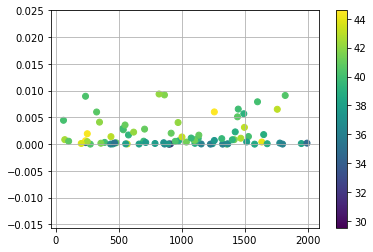

In [44]:
import matplotlib.pyplot as plt
plt.scatter(params[:,1],params[:,0],c=UAR[:]*100,)
plt.colorbar()
# plt.yscale('log')
plt.grid()
plt.show()

In [45]:
1258 +200

1458

In [46]:
10 ** best['lr']

0.006028585143146318

In [47]:
200 + best['num_dense1']

1458

In [48]:
20 + best['num_dense2']

179

In [1]:
from sklearn.metrics import confusion_matrix

In [6]:
confusion_matrix(y_pred=[0, 2, 1, 0, 0, 1],y_true=[0, 1, 2, 0, 1, 2])[0,0]/sum(confusion_matrix(y_pred=[0, 2, 1, 0, 0, 1],y_true=[0, 1, 2, 0, 1, 2])[0,:])

1.0